TODO: remove this, and make sure this works on main.

In [17]:
%%bash

[ ! -d "ocp" ] && git clone https://github.com/emsunshine/ocp.git

cd ocp
git pull
git checkout ase_datasets_bugfixes
pip install -e .
git rev-parse HEAD

Already up to date.


Already on 'ase_datasets_bugfixes'


Your branch is up to date with 'origin/ase_datasets_bugfixes'.
Obtaining file:///home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for ocp-models (pyproject.toml): started
  Building editable for ocp-models (pyproject.toml): finished with status 'done'
  Created wheel for ocp-models: filename=ocp_models-0.0.3-0.editable-py3-none-any.whl size=3335 sha256=272b159896a80099e9f985882b83d4c3a10eabd42f23e831d4e19bdfd238fa2b
  Stored in directory: /tmp/pip-ephem-w

# Fine tuning a model

In this section we look at how to improve a model. We start by using a pre-trained model to predict the energies of several oxide polymorphs. The data here comes from this paper:

Identifying Potential BO2 Oxide Polymorphs for Epitaxial Growth Candidates
Mehta, P., Salvador, P. A., & Kitchin, J. R. (2015). Identifying potential BO2 oxide polymorphs for epitaxial growth candidates. ACS Appl. Mater. Interfaces, 6(5), 3630–3639. http://dx.doi.org/10.1021/am4059149

This data set shows equations of state for several oxide/polymorph combinations. I use this dataset to compare with predictions from OCP

First we get the checkpoint that we want. According to the [MODELS](https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md#s2ef-models) the GemNet-OC	OC20+OC22 combination has an energy MAE of 0.483 which seems like a good place to start. This model was trained on oxides.

We get this checkpoint here.

In [17]:
import os
import requests

checkpoint = 'gnoc_oc22_oc20_all_s2ef.pt'

if not os.path.exists(checkpoint):
    url = 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt'
    with open(checkpoint, 'wb') as f:
        f.write(requests.get(url).content)

The data we need is provided in `supporting-information.json`. That file is embedded in the supporting information for the article, and is provided here in the tutorial. We load this data and explore it a little. The json file provides a dictionary with the structure:

    [oxide][polymorph][xc][EOS][configurations]
    
The first key is a composition, the second is a string for the polymorph structure, the third indicates which XC functional was used (we focus on PBE here), the fourth key is for the Equation of State calculations, and the last key is a list of results for the EOS. 

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms

with open('supporting-information.json', 'rb') as f:
     d = json.loads(f.read())
        

oxides = list(d.keys())
polymorphs = list(d['TiO2'].keys())
oxides, polymorphs

(['SnO2', 'IrO2', 'RuO2', 'TiO2', 'VO2'],
 ['rutile', 'pyrite', 'columbite', 'brookite', 'fluorite', 'anatase'])

A specific calculation has a lot of details in it. You can use this to recreate the calculations. Shortly we will use these to compare the DFT results to OCP.

In [19]:
d['TiO2']['rutile']['PBE']['EOS']['calculations'][0]

{'incar': {'doc': 'INCAR parameters',
  'prec': 'Normal',
  'isif': 4,
  'nbands': 20,
  'ibrion': 2,
  'gga': 'PE',
  'encut': 520.0,
  'ismear': 0,
  'sigma': 0.001,
  'nsw': 50},
 'doc': 'JSON representation of a VASP calculation.\n\nenergy is in eV\nforces are in eV/\\AA\nstress is in GPa (sxx, syy, szz,  syz, sxz, sxy)\nmagnetic moments are in Bohr-magneton\nThe density of states is reported with E_f at 0 eV.\nVolume is reported in \\AA^3\nCoordinates and cell parameters are reported in \\AA\n\nIf atom-projected dos are included they are in the form:\n{ados:{energy:data, {atom index: {orbital : dos}}}\n',
 'potcar': [['O',
   'potpaw/O/POTCAR',
   '0cf2ce56049ca395c567026b700ed66c94a85161'],
  ['Ti', 'potpaw/Ti/POTCAR', '51f7f05982d6b4052becc160375a8b8b670177a7']],
 'input': {'kpts': [6, 6, 6],
  'reciprocal': False,
  'xc': 'LDA',
  'kpts_nintersections': None,
  'setups': None,
  'txt': '-',
  'gamma': False},
 'atoms': {'cell': [[4.3789762519649225, 0.0, 0.0],
   [0.0, 4.378976

For each result we can retrieve the atomic geometry, energy and forces from the json file. We use these to recreate an Atoms object. Here is an example.

In [20]:
c = d['TiO2']['rutile']['PBE']['EOS']['calculations'][0]
atoms = Atoms(symbols=c['atoms']['symbols'],
              positions=c['atoms']['positions'],
              cell=c['atoms']['cell'],
              pbc=c['atoms']['pbc'])
atoms.set_tags(np.ones(len(atoms)))
atoms, c['data']['total_energy'], c['data']['forces']

(Atoms(symbols='Ti2O4', pbc=True, cell=[4.3789762519649225, 4.3789762519649225, 2.864091775985314], tags=...),
 -56.230672,
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [-0.001264, -0.001264, 0.0],
  [0.001264, 0.001264, 0.0],
  [-0.001264, 0.001264, 0.0],
  [0.001264, -0.001264, 0.0]])

Next, we will create an OCP calculator that we can use to get predictions from.

In [65]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
calc = OCPCalculator(checkpoint=os.path.expanduser(checkpoint), cpu=False)

amp: false
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/checkpoints/2023-07-18-17-25-20
  commit: 999c1ac
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/logs/tensorboard/2023-07-18-17-25-20
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/results/2023-07-18-17-25-20
  seed: null
  timestamp_id: 2023-07-18-17-25-20
dataset: null
gpus: 1
logger: tensorboard
model: gemnet_oc
model_attributes:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_quad_in: 32
  emb_size_quad_out: 32
  emb_size_rbf: 16
  emb_size_sbf: 32
  emb_size_trip_

Now, we loop through each structure and accumulate the OCP predictions. Then, we plot the parity results.

Elapsed time 16.4 seconds.


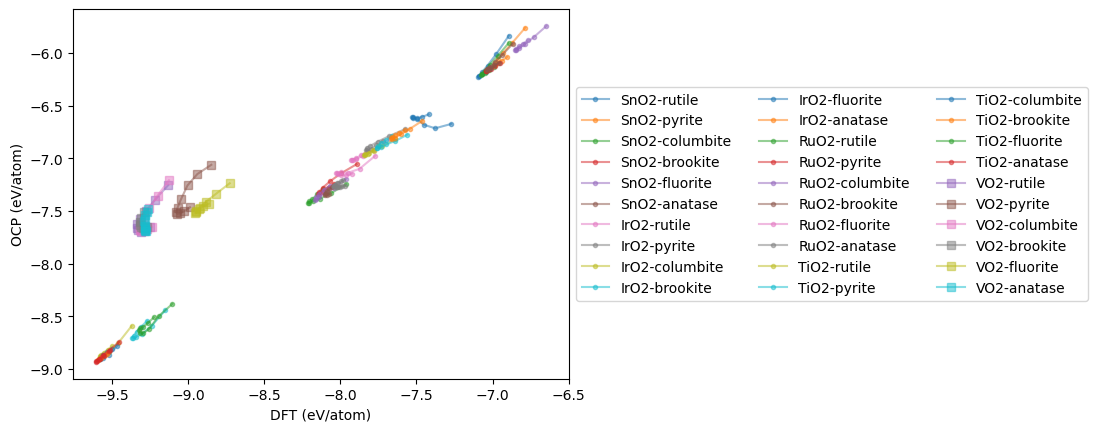

In [66]:
import time
t0 = time.time()

eos_data = {}
for oxide in oxides:
    eos_data[oxide] = {}
    for polymorph in polymorphs:
        dft = []
        ocp = []
        vols = []
        calculations = d[oxide][polymorph]['PBE']['EOS']['calculations']
        for c in calculations:
                        
            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))
            
            atoms.calc = calc
            ocp += [atoms.get_potential_energy() / len(atoms)]
            dft += [c['data']['total_energy'] / len(atoms)]
            vols += [atoms.get_volume()]
        plt.plot(dft, ocp, marker='s' if oxide == 'VO2' else '.',
                 alpha=0.5, label=f'{oxide}-{polymorph}')
        eos_data[oxide][polymorph] = (vols, dft, ocp)
        
plt.xlabel('DFT (eV/atom)')
plt.ylabel('OCP (eV/atom)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);
print(f'Elapsed time {time.time() - t0:1.1f} seconds.')

In [67]:
mae = np.mean(np.abs(np.array(dft) - np.array(ocp)))
print(f'MAE = {mae:1.3f} eV/atom')

MAE = 1.668 eV/atom


The MAE is somewhat high compared to the reported value of 0.458 eV. That is not too surprising; although OC22 was trained on oxides, it was not trained on all of these structures. It is also evident on inspection that the main issues are all the VO2 structures, and these skew the MAE. Next we look at the EOS for each material. Here you can see offsets, and qualitative issues in the shapes. The offset is largely a PBE/RPBE difference.

Some notable issues are with fluorite structures

In [ ]:
for oxide in eos_data:
    for polymorph in eos_data[oxide]:
        V, D, O = eos_data[oxide][polymorph]
        plt.figure()
        plt.plot(V, D, label='dft')
        plt.plot(V, O, label='ocp')
        plt.title(f'{oxide} - {polymorph}')
        plt.legend()

We can improve this by fine-tuning the model.

# Fine tuning the checkpoint

There are severeal steps in fine-tuning:
1. Create train, test, val datasets
2. Create a configuration yml file
3. Run the training
4. Check the results

First we create the training databases. OCP supports ase databases, so we use those here. The first step is to make a database containing the data. We need to write an atoms object with an attached SinglePointCalculator for each structure.

In [22]:
from ase.db import connect
from ase.calculators.singlepoint import SinglePointCalculator

! rm -fr oxides.db  # start clean when you run this cell
db = connect('oxides.db')

In [23]:
for oxide in oxides:
    for polymorph in polymorphs:
        for c in d[oxide][polymorph]['PBE']['EOS']['calculations']:
            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))
            calc = SinglePointCalculator(atoms, 
                                         energy=c['data']['total_energy'],
                                         forces=c['data']['forces'])
            atoms.set_calculator(calc)
            db.write(atoms)

Let's see what we made.

In [24]:
! ase db oxides.db

id|age|formula|calculator| energy|natoms| fmax|pbc| volume|charge|   mass
 1| 4s|Sn2O4  |unknown   |-41.359|     6|0.045|TTT| 64.258| 0.000|301.416
 2| 4s|Sn2O4  |unknown   |-41.853|     6|0.025|TTT| 66.526| 0.000|301.416
 3| 4s|Sn2O4  |unknown   |-42.199|     6|0.010|TTT| 68.794| 0.000|301.416
 4| 4s|Sn2O4  |unknown   |-42.419|     6|0.006|TTT| 71.062| 0.000|301.416
 5| 4s|Sn2O4  |unknown   |-42.534|     6|0.011|TTT| 73.330| 0.000|301.416
 6| 4s|Sn2O4  |unknown   |-42.562|     6|0.029|TTT| 75.598| 0.000|301.416
 7| 4s|Sn2O4  |unknown   |-42.518|     6|0.033|TTT| 77.866| 0.000|301.416
 8| 4s|Sn2O4  |unknown   |-42.415|     6|0.010|TTT| 80.134| 0.000|301.416
 9| 4s|Sn2O4  |unknown   |-42.266|     6|0.006|TTT| 82.402| 0.000|301.416
10| 4s|Sn2O4  |unknown   |-42.083|     6|0.017|TTT| 84.670| 0.000|301.416
11| 4s|Sn4O8  |unknown   |-81.424|    12|0.012|TTT|117.473| 0.000|602.832
12| 4s|Sn4O8  |unknown   |-82.437|    12|0.005|TTT|121.620| 0.000|602.832
13| 4s|Sn4O8  |unknown   |-83.147|    

## Make the train, test, val splits

We need to split the ase-db into three separate databases, one for training (80%), one for testing (10%) and one for validation. We generate a list of ids and then shuffle them. Then we write the first 80% into `train.db`, the next 10% into `test.db`, and the remaining into `val.db`.

The train set is used for training. The test and val sets are used to check for overfitting.

You choose the splits you want, 80:10:10 is common. We take a simple approach to split the database here. We make an array of integers that correspond to the ids, randomly shuffle them, and then get each row in the randomized order and write them to a new db.

In [25]:
import numpy as np
rng = np.random.default_rng(seed=42)

ids = np.arange(1, 296)
rng.shuffle(ids)
ids 

array([271,  97, 101,  27,  20, 261, 194, 264,  71, 133, 267, 162, 160,
        76, 214, 246,   1, 243, 119, 293,  51,  90, 185, 136, 281, 189,
       280,  69, 218,   4, 292,  13,  93, 253, 270,   3,  81,  65,  47,
       169, 198,  52,  39,  62, 269, 222,  25, 144, 237, 226,  57, 166,
       286, 154, 254, 170, 181, 139,  99, 228, 145, 244, 279, 223, 186,
       248, 192, 132,  83, 233, 277,  55, 282,  63, 146, 240, 105, 147,
       262, 221,  31, 256, 199, 116,  48,  59,   8,  28, 245, 149,  61,
        85, 150, 135, 274, 128, 294, 272, 165,  38, 102, 263, 257, 172,
       182, 206,  21, 258, 127, 220, 151,  34,   9,  89, 203, 295, 204,
       113, 208,  26, 167,  30,  78,  80, 287,  96, 108, 193,  67,  10,
       249, 173,  60, 250, 229,   5, 212,  49,  68, 190,  95, 153, 180,
       125,  73, 134, 291, 159,  33, 156, 157, 231, 174, 122, 288, 131,
       109,  82, 163, 210,  56, 175,  53, 236,  87,  29,  12, 107, 255,
       121, 141, 290, 217, 129, 260, 289,  92, 179,  40, 202, 14

In [26]:
train_end = int(len(ids) * 0.8)
test_end = train_end + int(len(ids) * 0.1)

! rm -fr train.db test.db val.db # start clean

train = connect('train.db')
test = connect('test.db')
val = connect('val.db')

for _id in ids[0:train_end]:
    row = db.get(id=int(_id))
    train.write(row.toatoms())
    
for _id in ids[train_end:test_end]:
    row = db.get(id=int(_id))
    test.write(row.toatoms())
    
for _id in ids[test_end:]:
    row = db.get(id=int(_id))
    val.write(row.toatoms())

In [27]:
train.count(), test.count(), val.count()

(236, 29, 30)

## Setting up the configuration yaml file

We have to create a yaml configuration file for the model we are using. We derive these from files that are installed with `ocp`. Here we use Python to find them. Check the [MODELS](https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md) page to see which config to use for the checkpoint we are using here.

According to the documentation, we need configs/oc22/s2ef/gemnet-oc/gemnet_oc_oc20_oc22.yml

In [28]:
from pathlib import Path
import ocpmodels as om
import os

ocp_root = Path(om.__file__).parent.parent
print(ocp_root)
os.listdir(ocp_root / 'configs/oc22/s2ef/gemnet-oc')

/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp


['gemnet_oc_finetune.yml',
 'gemnet_oc_oc20_oc22_degen_edges.yml',
 'gemnet_oc_oc20_oc22.yml',
 'gemnet_oc.yml']

There are many ways you could build a YAML file. Here we do it programmatically. This is more reproducible than editing the file by hand. One downside of using Python here is the order of the yaml file is not preserved, so the output files don't look like the input files. That is ok.

We write the file to run.yml in the current directory.

In [29]:
ocp_root / 'configs/oc22/s2ef/gemnet-oc/gemnet_oc.yml'
! ls /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp/configs/oc22/s2ef/gemnet-oc/gemnet_oc.yml

/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp/configs/oc22/s2ef/gemnet-oc/gemnet_oc.yml


In [70]:
from yaml import load, dump
from yaml import CLoader as Loader, CDumper as Dumper

with open(ocp_root / 'configs/oc22/s2ef/base_joint.yml') as f:
    yml = load(f, Loader=Loader)
    
#with open(ocp_root / 'configs/oc22/s2ef/gemnet-oc/gemnet_oc.yml') as f:
with open(Path(om.__file__).parent.parent / 'configs/oc22/s2ef/gemnet-oc/gemnet_oc_oc20_oc22.yml') as f:
    yml.update(load(f, Loader=Loader))
    del yml['includes']  # OCP uses relative paths here. We don't need an include anymore since we load base above.
    
yml.update(dict(task=dict(dataset='ase_db'),
                dataset=dict(train=dict(src=str(Path('train.db').absolute()),
                                        a2g_args=dict(r_energy=True, r_forces=True),
                                        keep_in_memory=True),
                             # for test, we only do predictions so we do not need to regress
                             # energy or forces
                            test=dict(src=str(Path('test.db').absolute()),
                                      a2g_args=dict(r_energy=False, r_forces=False),
                                      keep_in_memory=True),
                            val=dict(src=str(Path('val.db').absolute()),
                                      a2g_args=dict(r_energy=True, r_forces=True),
                                      keep_in_memory=True),)))

# This setting determines when checkpoints are saved
del yml['optim']['eval_every']
del yml['logger']
del yml['optim']['loss_force'] # causes an error


runyml = Path('run.yml').absolute()
with open(runyml, 'wb') as f:
    f.write(dump(yml).encode('utf-8'))
    
runyml

PosixPath('/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/run.yml')

In [71]:
! cat run.yml

dataset:
  test:
    a2g_args:
      r_energy: false
      r_forces: false
    keep_in_memory: true
    src: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/test.db
  train:
    a2g_args:
      r_energy: true
      r_forces: true
    keep_in_memory: true
    src: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/train.db
  val:
    a2g_args:
      r_energy: true
      r_forces: true
    keep_in_memory: true
    src: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/val.db
model:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_quad_in: 32
  emb_size_quad_out: 32
  emb_size_rbf: 16
  emb_size_sbf: 32
  emb_size_trip_in

## Running the training job

`ocp` provides a `main.py` file that is used for training. You have to run this file from the ocp root directory. The following cells show how to get the arguments you need to build up the command to run.

You need absolute paths to your run.yml file, and to the checkpoint file.

Here we construct the Python command you need to run. You need to run this cell, then copy the results into the next cell with a bash cell-magic.

In [57]:
cmd = f'''cd {ocp_root} 
python main.py --mode train \\
 --config-yml {Path("run.yml").absolute()} \\
 --checkpoint {Path("gnoc_oc22_oc20_all_s2ef.pt").absolute()}'''
print(cmd)

cd /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp 
python main.py --mode train \
 --config-yml /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/run.yml \
 --checkpoint /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/gnoc_oc22_oc20_all_s2ef.pt


In [72]:
%%bash
cd /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp 
git rev-parse HEAD
python main.py --mode train \
 --config-yml /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/run.yml \
 --checkpoint /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/gnoc_oc22_oc20_all_s2ef.pt

999c1ac8d1863c2fb666b1b22a59e3fc29725b52
2023-07-18 17:37:41 (INFO): Project root: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp
amp: false
cmd:
  checkpoint_dir: ./checkpoints/2023-07-18-17-38-08
  commit: 999c1ac
  identifier: ''
  logs_dir: ./logs/tensorboard/2023-07-18-17-38-08
  print_every: 10
  results_dir: ./results/2023-07-18-17-38-08
  seed: 0
  timestamp_id: 2023-07-18-17-38-08
dataset:
  a2g_args:
    r_energy: true
    r_forces: true
  keep_in_memory: true
  src: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/train.db
gpus: 1
logger: tensorboard
model: gemnet_oc
model_attributes:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512

2023-07-18 17:37:50 (WARNING): Model gradient logging to tensorboard not yet supported.


2023-07-18 17:37:50 (INFO): Loading checkpoint from: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/gnoc_oc22_oc20_all_s2ef.pt
2023-07-18 17:37:50 (INFO): Overwriting scaling factors with those loaded from checkpoint. If you're generating predictions with a pretrained checkpoint, this is the correct behavior. To disable this, delete `scale_dict` from the checkpoint. 
2023-07-18 17:37:55 (INFO): forcesx_mae: 3.36e-02, forcesy_mae: 2.96e-02, forcesz_mae: 3.91e-02, forces_mae: 3.41e-02, forces_cos: 9.96e-02, forces_magnitude: 5.46e-02, energy_mae: 6.91e+00, energy_force_within_threshold: 6.25e-03, loss: 7.01e+00, lr: 5.00e-04, epoch: 6.67e-01, step: 1.00e+01
2023-07-18 17:37:57 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


2023-07-18 17:37:57 (INFO): forcesx_mae: 0.0248, forcesy_mae: 0.0188, forcesz_mae: 0.0250, forces_mae: 0.0229, forces_cos: 0.0523, forces_magnitude: 0.0356, energy_mae: 5.2334, energy_force_within_threshold: 0.0000, loss: 5.2262, epoch: 1.0000
2023-07-18 17:37:57 (INFO): Predicting on test.


device 0: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp/ocpmodels/trainers/forces_trainer.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions["forces"] = np.array(predictions["forces"])
/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp/ocpmodels/trainers/base_trainer.py:794: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(gather_results[k])[idx]


2023-07-18 17:37:58 (INFO): Writing results to ./results/2023-07-18-17-38-08/s2ef_predictions.npz
2023-07-18 17:37:59 (INFO): forcesx_mae: 2.21e-02, forcesy_mae: 1.98e-02, forcesz_mae: 2.37e-02, forces_mae: 2.19e-02, forces_cos: -4.17e-02, forces_magnitude: 3.09e-02, energy_mae: 2.07e+00, energy_force_within_threshold: 6.41e-03, loss: 2.16e+00, lr: 5.00e-04, epoch: 1.33e+00, step: 2.00e+01
2023-07-18 17:38:01 (INFO): forcesx_mae: 2.87e-02, forcesy_mae: 2.26e-02, forcesz_mae: 3.00e-02, forces_mae: 2.71e-02, forces_cos: 2.40e-03, forces_magnitude: 3.80e-02, energy_mae: 5.54e+00, energy_force_within_threshold: 6.41e-03, loss: 5.74e+00, lr: 5.00e-04, epoch: 2.00e+00, step: 3.00e+01
2023-07-18 17:38:02 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


2023-07-18 17:38:02 (INFO): forcesx_mae: 0.0157, forcesy_mae: 0.0187, forcesz_mae: 0.0142, forces_mae: 0.0162, forces_cos: 0.0960, forces_magnitude: 0.0176, energy_mae: 4.9279, energy_force_within_threshold: 0.0000, loss: 4.9632, epoch: 2.0000
2023-07-18 17:38:05 (INFO): forcesx_mae: 2.14e-02, forcesy_mae: 1.62e-02, forcesz_mae: 1.91e-02, forces_mae: 1.89e-02, forces_cos: -4.41e-03, forces_magnitude: 2.13e-02, energy_mae: 3.53e+00, energy_force_within_threshold: 0.00e+00, loss: 3.59e+00, lr: 5.00e-04, epoch: 2.67e+00, step: 4.00e+01
2023-07-18 17:38:07 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:38:07 (INFO): forcesx_mae: 0.0118, forcesy_mae: 0.0151, forcesz_mae: 0.0137, forces_mae: 0.0135, forces_cos: 0.0008, forces_magnitude: 0.0156, energy_mae: 1.6555, energy_force_within_threshold: 0.0000, loss: 1.6985, epoch: 3.0000
2023-07-18 17:38:09 (INFO): forcesx_mae: 1.69e-02, forcesy_mae: 1.41e-02, forcesz_mae: 1.42e-02, forces_mae: 1.51e-02, forces_cos: 7.81e-02, forces_magnitude: 1.75e-02, energy_mae: 1.71e+00, energy_force_within_threshold: 0.00e+00, loss: 1.78e+00, lr: 5.00e-04, epoch: 3.33e+00, step: 5.00e+01
2023-07-18 17:38:11 (INFO): forcesx_mae: 1.11e-02, forcesy_mae: 1.09e-02, forcesz_mae: 1.05e-02, forces_mae: 1.08e-02, forces_cos: 1.20e-02, forces_magnitude: 1.16e-02, energy_mae: 3.10e+00, energy_force_within_threshold: 6.41e-03, loss: 3.10e+00, lr: 5.00e-04, epoch: 4.00e+00, step: 6.00e+01
2023-07-18 17:38:11 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


2023-07-18 17:38:12 (INFO): forcesx_mae: 0.0143, forcesy_mae: 0.0141, forcesz_mae: 0.0120, forces_mae: 0.0135, forces_cos: 0.0440, forces_magnitude: 0.0145, energy_mae: 1.7120, energy_force_within_threshold: 0.0333, loss: 1.7448, epoch: 4.0000
2023-07-18 17:38:12 (INFO): Predicting on test.


device 0: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


2023-07-18 17:38:12 (INFO): Writing results to ./results/2023-07-18-17-38-08/s2ef_predictions.npz
2023-07-18 17:38:15 (INFO): forcesx_mae: 1.37e-02, forcesy_mae: 1.19e-02, forcesz_mae: 1.30e-02, forces_mae: 1.29e-02, forces_cos: 3.47e-02, forces_magnitude: 1.41e-02, energy_mae: 1.39e+00, energy_force_within_threshold: 1.25e-02, loss: 1.43e+00, lr: 5.00e-04, epoch: 4.67e+00, step: 7.00e+01
2023-07-18 17:38:17 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2023-07-18 17:38:17 (INFO): forcesx_mae: 0.0188, forcesy_mae: 0.0145, forcesz_mae: 0.0151, forces_mae: 0.0161, forces_cos: 0.0642, forces_magnitude: 0.0226, energy_mae: 0.9876, energy_force_within_threshold: 0.0000, loss: 1.0284, epoch: 5.0000
2023-07-18 17:38:18 (INFO): forcesx_mae: 1.82e-02, forcesy_mae: 1.47e-02, forcesz_mae: 1.66e-02, forces_mae: 1.65e-02, forces_cos: 1.88e-02, forces_magnitude: 2.06e-02, energy_mae: 1.46e+00, energy_force_within_threshold: 0.00e+00, loss: 1.50e+00, lr: 4.00e-04, epoch: 5.33e+00, step: 8.00e+01
2023-07-18 17:38:20 (INFO): forcesx_mae: 1.30e-02, forcesy_mae: 1.26e-02, forcesz_mae: 1.22e-02, forces_mae: 1.26e-02, forces_cos: 1.54e-01, forces_magnitude: 1.46e-02, energy_mae: 1.01e+00, energy_force_within_threshold: 0.00e+00, loss: 1.04e+00, lr: 4.00e-04, epoch: 6.00e+00, step: 9.00e+01
2023-07-18 17:38:21 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2023-07-18 17:38:22 (INFO): forcesx_mae: 0.0110, forcesy_mae: 0.0117, forcesz_mae: 0.0104, forces_mae: 0.0110, forces_cos: 0.0392, forces_magnitude: 0.0143, energy_mae: 0.7074, energy_force_within_threshold: 0.0000, loss: 0.7499, epoch: 6.0000
2023-07-18 17:38:24 (INFO): forcesx_mae: 1.05e-02, forcesy_mae: 9.64e-03, forcesz_mae: 1.03e-02, forces_mae: 1.01e-02, forces_cos: 7.82e-02, forces_magnitude: 1.19e-02, energy_mae: 2.38e+00, energy_force_within_threshold: 0.00e+00, loss: 2.41e+00, lr: 4.00e-04, epoch: 6.67e+00, step: 1.00e+02
2023-07-18 17:38:26 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


2023-07-18 17:38:26 (INFO): forcesx_mae: 0.0127, forcesy_mae: 0.0137, forcesz_mae: 0.0111, forces_mae: 0.0125, forces_cos: 0.0490, forces_magnitude: 0.0138, energy_mae: 0.6282, energy_force_within_threshold: 0.0667, loss: 0.6713, epoch: 7.0000
2023-07-18 17:38:26 (INFO): Predicting on test.


device 0: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


2023-07-18 17:38:27 (INFO): Writing results to ./results/2023-07-18-17-38-08/s2ef_predictions.npz
2023-07-18 17:38:28 (INFO): forcesx_mae: 1.08e-02, forcesy_mae: 1.10e-02, forcesz_mae: 1.12e-02, forces_mae: 1.10e-02, forces_cos: -2.21e-03, forces_magnitude: 1.44e-02, energy_mae: 2.01e+00, energy_force_within_threshold: 1.28e-02, loss: 2.03e+00, lr: 4.00e-04, epoch: 7.33e+00, step: 1.10e+02
2023-07-18 17:38:30 (INFO): forcesx_mae: 9.28e-03, forcesy_mae: 9.29e-03, forcesz_mae: 9.66e-03, forces_mae: 9.41e-03, forces_cos: 3.65e-02, forces_magnitude: 1.28e-02, energy_mae: 1.83e+00, energy_force_within_threshold: 0.00e+00, loss: 1.85e+00, lr: 4.00e-04, epoch: 8.00e+00, step: 1.20e+02
2023-07-18 17:38:31 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


2023-07-18 17:38:32 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0112, forcesz_mae: 0.0074, forces_mae: 0.0094, forces_cos: -0.0569, forces_magnitude: 0.0138, energy_mae: 1.7743, energy_force_within_threshold: 0.0000, loss: 1.7889, epoch: 8.0000
2023-07-18 17:38:34 (INFO): forcesx_mae: 8.53e-03, forcesy_mae: 7.46e-03, forcesz_mae: 8.45e-03, forces_mae: 8.14e-03, forces_cos: 7.51e-02, forces_magnitude: 1.07e-02, energy_mae: 1.44e+00, energy_force_within_threshold: 6.25e-03, loss: 1.46e+00, lr: 4.00e-04, epoch: 8.67e+00, step: 1.30e+02
2023-07-18 17:38:36 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


2023-07-18 17:38:36 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0103, forcesz_mae: 0.0080, forces_mae: 0.0091, forces_cos: -0.0957, forces_magnitude: 0.0150, energy_mae: 1.8108, energy_force_within_threshold: 0.0333, loss: 1.8181, epoch: 9.0000
2023-07-18 17:38:38 (INFO): forcesx_mae: 1.01e-02, forcesy_mae: 9.91e-03, forcesz_mae: 9.42e-03, forces_mae: 9.81e-03, forces_cos: 1.16e-01, forces_magnitude: 1.60e-02, energy_mae: 1.80e+00, energy_force_within_threshold: 1.28e-02, loss: 1.84e+00, lr: 3.20e-04, epoch: 9.33e+00, step: 1.40e+02
2023-07-18 17:38:40 (INFO): forcesx_mae: 8.19e-03, forcesy_mae: 9.05e-03, forcesz_mae: 8.71e-03, forces_mae: 8.65e-03, forces_cos: 1.29e-01, forces_magnitude: 1.31e-02, energy_mae: 1.33e+00, energy_force_within_threshold: 2.56e-02, loss: 1.34e+00, lr: 3.20e-04, epoch: 1.00e+01, step: 1.50e+02
2023-07-18 17:38:41 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


2023-07-18 17:38:41 (INFO): forcesx_mae: 0.0103, forcesy_mae: 0.0112, forcesz_mae: 0.0074, forces_mae: 0.0096, forces_cos: 0.0484, forces_magnitude: 0.0141, energy_mae: 1.0718, energy_force_within_threshold: 0.0333, loss: 1.0969, epoch: 10.0000
2023-07-18 17:38:44 (INFO): forcesx_mae: 1.24e-02, forcesy_mae: 1.17e-02, forcesz_mae: 1.15e-02, forces_mae: 1.18e-02, forces_cos: 7.44e-02, forces_magnitude: 1.18e-02, energy_mae: 1.56e+00, energy_force_within_threshold: 1.25e-02, loss: 1.59e+00, lr: 3.20e-04, epoch: 1.07e+01, step: 1.60e+02
2023-07-18 17:38:45 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


2023-07-18 17:38:46 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0102, forcesz_mae: 0.0070, forces_mae: 0.0086, forces_cos: 0.0830, forces_magnitude: 0.0133, energy_mae: 2.5211, energy_force_within_threshold: 0.0000, loss: 2.5156, epoch: 11.0000
2023-07-18 17:38:47 (INFO): forcesx_mae: 9.09e-03, forcesy_mae: 9.54e-03, forcesz_mae: 8.69e-03, forces_mae: 9.11e-03, forces_cos: 1.27e-01, forces_magnitude: 1.32e-02, energy_mae: 1.27e+00, energy_force_within_threshold: 6.41e-03, loss: 1.29e+00, lr: 3.20e-04, epoch: 1.13e+01, step: 1.70e+02
2023-07-18 17:38:49 (INFO): forcesx_mae: 8.96e-03, forcesy_mae: 9.23e-03, forcesz_mae: 8.61e-03, forces_mae: 8.93e-03, forces_cos: 1.30e-01, forces_magnitude: 1.23e-02, energy_mae: 6.49e-01, energy_force_within_threshold: 1.28e-02, loss: 6.75e-01, lr: 3.20e-04, epoch: 1.20e+01, step: 1.80e+02
2023-07-18 17:38:50 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


2023-07-18 17:38:50 (INFO): forcesx_mae: 0.0090, forcesy_mae: 0.0106, forcesz_mae: 0.0072, forces_mae: 0.0089, forces_cos: -0.1007, forces_magnitude: 0.0133, energy_mae: 1.3148, energy_force_within_threshold: 0.0000, loss: 1.3256, epoch: 12.0000
2023-07-18 17:38:53 (INFO): forcesx_mae: 9.31e-03, forcesy_mae: 8.85e-03, forcesz_mae: 8.58e-03, forces_mae: 8.92e-03, forces_cos: 1.00e-01, forces_magnitude: 1.31e-02, energy_mae: 1.30e+00, energy_force_within_threshold: 1.87e-02, loss: 1.33e+00, lr: 3.20e-04, epoch: 1.27e+01, step: 1.90e+02
2023-07-18 17:38:55 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


2023-07-18 17:38:55 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0105, forcesz_mae: 0.0073, forces_mae: 0.0090, forces_cos: -0.0841, forces_magnitude: 0.0130, energy_mae: 0.5096, energy_force_within_threshold: 0.0000, loss: 0.5373, epoch: 13.0000
2023-07-18 17:38:56 (INFO): forcesx_mae: 7.63e-03, forcesy_mae: 8.58e-03, forcesz_mae: 8.54e-03, forces_mae: 8.25e-03, forces_cos: 1.10e-01, forces_magnitude: 1.18e-02, energy_mae: 7.55e-01, energy_force_within_threshold: 2.56e-02, loss: 7.90e-01, lr: 2.56e-04, epoch: 1.33e+01, step: 2.00e+02
2023-07-18 17:38:58 (INFO): forcesx_mae: 9.18e-03, forcesy_mae: 8.88e-03, forcesz_mae: 8.65e-03, forces_mae: 8.90e-03, forces_cos: 9.11e-02, forces_magnitude: 1.40e-02, energy_mae: 6.06e-01, energy_force_within_threshold: 1.28e-02, loss: 6.30e-01, lr: 2.56e-04, epoch: 1.40e+01, step: 2.10e+02
2023-07-18 17:38:59 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


2023-07-18 17:39:00 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0104, forcesz_mae: 0.0078, forces_mae: 0.0092, forces_cos: -0.0652, forces_magnitude: 0.0143, energy_mae: 0.4586, energy_force_within_threshold: 0.0333, loss: 0.4827, epoch: 14.0000
2023-07-18 17:39:02 (INFO): forcesx_mae: 8.45e-03, forcesy_mae: 8.17e-03, forcesz_mae: 9.05e-03, forces_mae: 8.56e-03, forces_cos: 1.49e-01, forces_magnitude: 1.12e-02, energy_mae: 8.86e-01, energy_force_within_threshold: 6.25e-03, loss: 9.12e-01, lr: 2.56e-04, epoch: 1.47e+01, step: 2.20e+02
2023-07-18 17:39:04 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2023-07-18 17:39:04 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0111, forcesz_mae: 0.0083, forces_mae: 0.0096, forces_cos: -0.0947, forces_magnitude: 0.0142, energy_mae: 0.7256, energy_force_within_threshold: 0.0000, loss: 0.7592, epoch: 15.0000
2023-07-18 17:39:06 (INFO): forcesx_mae: 9.11e-03, forcesy_mae: 9.04e-03, forcesz_mae: 7.92e-03, forces_mae: 8.69e-03, forces_cos: 1.48e-01, forces_magnitude: 1.30e-02, energy_mae: 6.39e-01, energy_force_within_threshold: 1.92e-02, loss: 6.61e-01, lr: 2.56e-04, epoch: 1.53e+01, step: 2.30e+02
2023-07-18 17:39:08 (INFO): forcesx_mae: 7.67e-03, forcesy_mae: 8.18e-03, forcesz_mae: 8.86e-03, forces_mae: 8.24e-03, forces_cos: 2.44e-01, forces_magnitude: 1.34e-02, energy_mae: 6.78e-01, energy_force_within_threshold: 1.92e-02, loss: 7.09e-01, lr: 2.56e-04, epoch: 1.60e+01, step: 2.40e+02
2023-07-18 17:39:09 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2023-07-18 17:39:09 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0104, forcesz_mae: 0.0078, forces_mae: 0.0091, forces_cos: -0.0890, forces_magnitude: 0.0146, energy_mae: 0.8004, energy_force_within_threshold: 0.0000, loss: 0.8180, epoch: 16.0000
2023-07-18 17:39:11 (INFO): forcesx_mae: 6.94e-03, forcesy_mae: 7.06e-03, forcesz_mae: 7.24e-03, forces_mae: 7.08e-03, forces_cos: 1.65e-01, forces_magnitude: 1.12e-02, energy_mae: 4.73e-01, energy_force_within_threshold: 1.87e-02, loss: 4.94e-01, lr: 2.56e-04, epoch: 1.67e+01, step: 2.50e+02
2023-07-18 17:39:13 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:39:14 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0102, forcesz_mae: 0.0074, forces_mae: 0.0088, forces_cos: -0.0086, forces_magnitude: 0.0151, energy_mae: 0.7150, energy_force_within_threshold: 0.0333, loss: 0.7347, epoch: 17.0000
2023-07-18 17:39:15 (INFO): forcesx_mae: 8.40e-03, forcesy_mae: 9.07e-03, forcesz_mae: 8.54e-03, forces_mae: 8.67e-03, forces_cos: 3.19e-01, forces_magnitude: 1.49e-02, energy_mae: 6.50e-01, energy_force_within_threshold: 2.56e-02, loss: 6.81e-01, lr: 2.05e-04, epoch: 1.73e+01, step: 2.60e+02
2023-07-18 17:39:17 (INFO): forcesx_mae: 7.81e-03, forcesy_mae: 8.06e-03, forcesz_mae: 8.14e-03, forces_mae: 8.00e-03, forces_cos: 2.73e-01, forces_magnitude: 1.31e-02, energy_mae: 4.36e-01, energy_force_within_threshold: 3.85e-02, loss: 4.59e-01, lr: 2.05e-04, epoch: 1.80e+01, step: 2.70e+02
2023-07-18 17:39:18 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2023-07-18 17:39:18 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0104, forcesz_mae: 0.0076, forces_mae: 0.0090, forces_cos: -0.0849, forces_magnitude: 0.0147, energy_mae: 0.5842, energy_force_within_threshold: 0.0000, loss: 0.6027, epoch: 18.0000
2023-07-18 17:39:21 (INFO): forcesx_mae: 8.24e-03, forcesy_mae: 8.99e-03, forcesz_mae: 8.34e-03, forces_mae: 8.52e-03, forces_cos: 2.64e-01, forces_magnitude: 1.28e-02, energy_mae: 5.45e-01, energy_force_within_threshold: 3.75e-02, loss: 5.70e-01, lr: 2.05e-04, epoch: 1.87e+01, step: 2.80e+02
2023-07-18 17:39:23 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2023-07-18 17:39:23 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0106, forcesz_mae: 0.0077, forces_mae: 0.0091, forces_cos: 0.0047, forces_magnitude: 0.0144, energy_mae: 0.6435, energy_force_within_threshold: 0.0000, loss: 0.6733, epoch: 19.0000
2023-07-18 17:39:24 (INFO): forcesx_mae: 6.76e-03, forcesy_mae: 7.62e-03, forcesz_mae: 7.54e-03, forces_mae: 7.31e-03, forces_cos: 2.65e-01, forces_magnitude: 1.04e-02, energy_mae: 6.79e-01, energy_force_within_threshold: 1.92e-02, loss: 7.08e-01, lr: 2.05e-04, epoch: 1.93e+01, step: 2.90e+02
2023-07-18 17:39:26 (INFO): forcesx_mae: 8.38e-03, forcesy_mae: 7.90e-03, forcesz_mae: 7.75e-03, forces_mae: 8.01e-03, forces_cos: 2.14e-01, forces_magnitude: 1.17e-02, energy_mae: 6.05e-01, energy_force_within_threshold: 3.21e-02, loss: 6.24e-01, lr: 2.05e-04, epoch: 2.00e+01, step: 3.00e+02
2023-07-18 17:39:27 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2023-07-18 17:39:28 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0105, forcesz_mae: 0.0076, forces_mae: 0.0092, forces_cos: -0.0589, forces_magnitude: 0.0138, energy_mae: 0.4247, energy_force_within_threshold: 0.0333, loss: 0.4514, epoch: 20.0000
2023-07-18 17:39:30 (INFO): forcesx_mae: 7.72e-03, forcesy_mae: 8.27e-03, forcesz_mae: 7.96e-03, forces_mae: 7.98e-03, forces_cos: 3.01e-01, forces_magnitude: 1.26e-02, energy_mae: 5.44e-01, energy_force_within_threshold: 1.87e-02, loss: 5.67e-01, lr: 2.05e-04, epoch: 2.07e+01, step: 3.10e+02
2023-07-18 17:39:32 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2023-07-18 17:39:32 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0106, forcesz_mae: 0.0074, forces_mae: 0.0091, forces_cos: -0.0354, forces_magnitude: 0.0128, energy_mae: 0.3579, energy_force_within_threshold: 0.0333, loss: 0.3861, epoch: 21.0000
2023-07-18 17:39:34 (INFO): forcesx_mae: 7.60e-03, forcesy_mae: 7.98e-03, forcesz_mae: 8.38e-03, forces_mae: 7.99e-03, forces_cos: 2.30e-01, forces_magnitude: 1.24e-02, energy_mae: 5.04e-01, energy_force_within_threshold: 2.56e-02, loss: 5.22e-01, lr: 1.64e-04, epoch: 2.13e+01, step: 3.20e+02
2023-07-18 17:39:36 (INFO): forcesx_mae: 8.67e-03, forcesy_mae: 8.31e-03, forcesz_mae: 7.92e-03, forces_mae: 8.30e-03, forces_cos: 1.97e-01, forces_magnitude: 1.21e-02, energy_mae: 5.94e-01, energy_force_within_threshold: 1.28e-02, loss: 6.23e-01, lr: 1.64e-04, epoch: 2.20e+01, step: 3.30e+02
2023-07-18 17:39:37 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


2023-07-18 17:39:37 (INFO): forcesx_mae: 0.0103, forcesy_mae: 0.0108, forcesz_mae: 0.0083, forces_mae: 0.0098, forces_cos: -0.0742, forces_magnitude: 0.0134, energy_mae: 0.4150, energy_force_within_threshold: 0.0000, loss: 0.4431, epoch: 22.0000
2023-07-18 17:39:39 (INFO): forcesx_mae: 7.27e-03, forcesy_mae: 8.28e-03, forcesz_mae: 7.51e-03, forces_mae: 7.69e-03, forces_cos: 2.89e-01, forces_magnitude: 1.15e-02, energy_mae: 4.77e-01, energy_force_within_threshold: 2.50e-02, loss: 5.00e-01, lr: 1.64e-04, epoch: 2.27e+01, step: 3.40e+02
2023-07-18 17:39:41 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:39:42 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0103, forcesz_mae: 0.0079, forces_mae: 0.0092, forces_cos: 0.1367, forces_magnitude: 0.0137, energy_mae: 0.4822, energy_force_within_threshold: 0.0333, loss: 0.5087, epoch: 23.0000
2023-07-18 17:39:43 (INFO): forcesx_mae: 8.05e-03, forcesy_mae: 8.34e-03, forcesz_mae: 7.87e-03, forces_mae: 8.09e-03, forces_cos: 2.39e-01, forces_magnitude: 1.19e-02, energy_mae: 5.16e-01, energy_force_within_threshold: 4.49e-02, loss: 5.39e-01, lr: 1.64e-04, epoch: 2.33e+01, step: 3.50e+02
2023-07-18 17:39:45 (INFO): forcesx_mae: 8.16e-03, forcesy_mae: 8.28e-03, forcesz_mae: 8.57e-03, forces_mae: 8.34e-03, forces_cos: 2.88e-01, forces_magnitude: 1.31e-02, energy_mae: 6.36e-01, energy_force_within_threshold: 1.28e-02, loss: 6.52e-01, lr: 1.64e-04, epoch: 2.40e+01, step: 3.60e+02
2023-07-18 17:39:46 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2023-07-18 17:39:46 (INFO): forcesx_mae: 0.0097, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0096, forces_cos: -0.0288, forces_magnitude: 0.0131, energy_mae: 0.7660, energy_force_within_threshold: 0.0000, loss: 0.7910, epoch: 24.0000
2023-07-18 17:39:49 (INFO): forcesx_mae: 7.77e-03, forcesy_mae: 8.06e-03, forcesz_mae: 7.32e-03, forces_mae: 7.72e-03, forces_cos: 2.48e-01, forces_magnitude: 1.15e-02, energy_mae: 5.76e-01, energy_force_within_threshold: 0.00e+00, loss: 5.99e-01, lr: 1.64e-04, epoch: 2.47e+01, step: 3.70e+02
2023-07-18 17:39:50 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


2023-07-18 17:39:51 (INFO): forcesx_mae: 0.0088, forcesy_mae: 0.0102, forcesz_mae: 0.0073, forces_mae: 0.0088, forces_cos: 0.0648, forces_magnitude: 0.0132, energy_mae: 0.5268, energy_force_within_threshold: 0.0000, loss: 0.5585, epoch: 25.0000
2023-07-18 17:39:52 (INFO): forcesx_mae: 7.72e-03, forcesy_mae: 8.34e-03, forcesz_mae: 8.93e-03, forces_mae: 8.33e-03, forces_cos: 2.66e-01, forces_magnitude: 1.32e-02, energy_mae: 4.99e-01, energy_force_within_threshold: 2.56e-02, loss: 5.30e-01, lr: 1.31e-04, epoch: 2.53e+01, step: 3.80e+02
2023-07-18 17:39:54 (INFO): forcesx_mae: 7.71e-03, forcesy_mae: 7.77e-03, forcesz_mae: 7.45e-03, forces_mae: 7.64e-03, forces_cos: 2.60e-01, forces_magnitude: 1.21e-02, energy_mae: 4.25e-01, energy_force_within_threshold: 6.41e-03, loss: 4.41e-01, lr: 1.31e-04, epoch: 2.60e+01, step: 3.90e+02
2023-07-18 17:39:55 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


2023-07-18 17:39:56 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0101, forcesz_mae: 0.0074, forces_mae: 0.0089, forces_cos: -0.0183, forces_magnitude: 0.0134, energy_mae: 0.3935, energy_force_within_threshold: 0.0333, loss: 0.4175, epoch: 26.0000
2023-07-18 17:39:58 (INFO): forcesx_mae: 7.12e-03, forcesy_mae: 6.66e-03, forcesz_mae: 6.74e-03, forces_mae: 6.84e-03, forces_cos: 3.21e-01, forces_magnitude: 1.07e-02, energy_mae: 3.43e-01, energy_force_within_threshold: 5.00e-02, loss: 3.63e-01, lr: 1.31e-04, epoch: 2.67e+01, step: 4.00e+02
2023-07-18 17:40:00 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


2023-07-18 17:40:00 (INFO): forcesx_mae: 0.0098, forcesy_mae: 0.0102, forcesz_mae: 0.0078, forces_mae: 0.0092, forces_cos: -0.0717, forces_magnitude: 0.0137, energy_mae: 0.3967, energy_force_within_threshold: 0.0667, loss: 0.4230, epoch: 27.0000
2023-07-18 17:40:02 (INFO): forcesx_mae: 8.30e-03, forcesy_mae: 8.88e-03, forcesz_mae: 8.12e-03, forces_mae: 8.43e-03, forces_cos: 3.08e-01, forces_magnitude: 1.37e-02, energy_mae: 4.38e-01, energy_force_within_threshold: 4.49e-02, loss: 4.57e-01, lr: 1.31e-04, epoch: 2.73e+01, step: 4.10e+02
2023-07-18 17:40:04 (INFO): forcesx_mae: 6.95e-03, forcesy_mae: 7.95e-03, forcesz_mae: 7.73e-03, forces_mae: 7.54e-03, forces_cos: 3.10e-01, forces_magnitude: 1.10e-02, energy_mae: 5.27e-01, energy_force_within_threshold: 3.21e-02, loss: 5.45e-01, lr: 1.31e-04, epoch: 2.80e+01, step: 4.20e+02
2023-07-18 17:40:04 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


2023-07-18 17:40:05 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0092, forces_cos: -0.0885, forces_magnitude: 0.0139, energy_mae: 0.5488, energy_force_within_threshold: 0.0667, loss: 0.5729, epoch: 28.0000
2023-07-18 17:40:07 (INFO): forcesx_mae: 6.96e-03, forcesy_mae: 7.49e-03, forcesz_mae: 7.46e-03, forces_mae: 7.30e-03, forces_cos: 2.65e-01, forces_magnitude: 1.14e-02, energy_mae: 4.67e-01, energy_force_within_threshold: 1.87e-02, loss: 4.89e-01, lr: 1.31e-04, epoch: 2.87e+01, step: 4.30e+02
2023-07-18 17:40:09 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


2023-07-18 17:40:09 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0092, forces_cos: -0.0379, forces_magnitude: 0.0134, energy_mae: 0.8412, energy_force_within_threshold: 0.0667, loss: 0.8605, epoch: 29.0000
2023-07-18 17:40:11 (INFO): forcesx_mae: 8.70e-03, forcesy_mae: 8.45e-03, forcesz_mae: 8.00e-03, forces_mae: 8.39e-03, forces_cos: 2.15e-01, forces_magnitude: 1.20e-02, energy_mae: 5.45e-01, energy_force_within_threshold: 3.85e-02, loss: 5.64e-01, lr: 1.05e-04, epoch: 2.93e+01, step: 4.40e+02
2023-07-18 17:40:13 (INFO): forcesx_mae: 7.58e-03, forcesy_mae: 8.21e-03, forcesz_mae: 7.62e-03, forces_mae: 7.80e-03, forces_cos: 3.45e-01, forces_magnitude: 1.25e-02, energy_mae: 4.50e-01, energy_force_within_threshold: 6.41e-03, loss: 4.66e-01, lr: 1.05e-04, epoch: 3.00e+01, step: 4.50e+02
2023-07-18 17:40:14 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:40:14 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0101, forcesz_mae: 0.0075, forces_mae: 0.0089, forces_cos: -0.0630, forces_magnitude: 0.0136, energy_mae: 0.2637, energy_force_within_threshold: 0.1000, loss: 0.2897, epoch: 30.0000
2023-07-18 17:40:14 (INFO): Predicting on test.


device 0: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


2023-07-18 17:40:15 (INFO): Writing results to ./results/2023-07-18-17-38-08/s2ef_predictions.npz
2023-07-18 17:40:17 (INFO): forcesx_mae: 7.41e-03, forcesy_mae: 7.44e-03, forcesz_mae: 7.24e-03, forces_mae: 7.37e-03, forces_cos: 2.98e-01, forces_magnitude: 1.13e-02, energy_mae: 2.65e-01, energy_force_within_threshold: 6.88e-02, loss: 2.86e-01, lr: 1.05e-04, epoch: 3.07e+01, step: 4.60e+02
2023-07-18 17:40:19 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:40:19 (INFO): forcesx_mae: 0.0104, forcesy_mae: 0.0109, forcesz_mae: 0.0086, forces_mae: 0.0099, forces_cos: -0.0710, forces_magnitude: 0.0129, energy_mae: 0.4263, energy_force_within_threshold: 0.0333, loss: 0.4539, epoch: 31.0000
2023-07-18 17:40:21 (INFO): forcesx_mae: 7.77e-03, forcesy_mae: 8.33e-03, forcesz_mae: 8.20e-03, forces_mae: 8.10e-03, forces_cos: 3.08e-01, forces_magnitude: 1.12e-02, energy_mae: 4.03e-01, energy_force_within_threshold: 2.56e-02, loss: 4.29e-01, lr: 1.05e-04, epoch: 3.13e+01, step: 4.70e+02
2023-07-18 17:40:23 (INFO): forcesx_mae: 7.85e-03, forcesy_mae: 7.48e-03, forcesz_mae: 7.31e-03, forces_mae: 7.55e-03, forces_cos: 2.36e-01, forces_magnitude: 1.03e-02, energy_mae: 4.89e-01, energy_force_within_threshold: 5.13e-02, loss: 5.14e-01, lr: 1.05e-04, epoch: 3.20e+01, step: 4.80e+02
2023-07-18 17:40:24 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


2023-07-18 17:40:24 (INFO): forcesx_mae: 0.0097, forcesy_mae: 0.0110, forcesz_mae: 0.0077, forces_mae: 0.0094, forces_cos: -0.2001, forces_magnitude: 0.0131, energy_mae: 0.5873, energy_force_within_threshold: 0.0333, loss: 0.6084, epoch: 32.0000
2023-07-18 17:40:27 (INFO): forcesx_mae: 7.37e-03, forcesy_mae: 7.87e-03, forcesz_mae: 7.02e-03, forces_mae: 7.42e-03, forces_cos: 2.90e-01, forces_magnitude: 1.21e-02, energy_mae: 3.88e-01, energy_force_within_threshold: 3.75e-02, loss: 4.10e-01, lr: 1.05e-04, epoch: 3.27e+01, step: 4.90e+02
2023-07-18 17:40:29 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:40:29 (INFO): forcesx_mae: 0.0085, forcesy_mae: 0.0102, forcesz_mae: 0.0072, forces_mae: 0.0086, forces_cos: 0.0814, forces_magnitude: 0.0146, energy_mae: 0.5983, energy_force_within_threshold: 0.0000, loss: 0.6217, epoch: 33.0000
2023-07-18 17:40:31 (INFO): forcesx_mae: 8.53e-03, forcesy_mae: 8.23e-03, forcesz_mae: 8.51e-03, forces_mae: 8.42e-03, forces_cos: 2.35e-01, forces_magnitude: 1.41e-02, energy_mae: 4.66e-01, energy_force_within_threshold: 3.21e-02, loss: 4.87e-01, lr: 8.39e-05, epoch: 3.33e+01, step: 5.00e+02
2023-07-18 17:40:33 (INFO): forcesx_mae: 7.02e-03, forcesy_mae: 7.37e-03, forcesz_mae: 7.37e-03, forces_mae: 7.26e-03, forces_cos: 3.52e-01, forces_magnitude: 1.13e-02, energy_mae: 3.71e-01, energy_force_within_threshold: 8.33e-02, loss: 4.06e-01, lr: 8.39e-05, epoch: 3.40e+01, step: 5.10e+02
2023-07-18 17:40:33 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


2023-07-18 17:40:34 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0095, forces_cos: -0.0999, forces_magnitude: 0.0134, energy_mae: 0.9882, energy_force_within_threshold: 0.0000, loss: 1.0051, epoch: 34.0000
2023-07-18 17:40:36 (INFO): forcesx_mae: 7.56e-03, forcesy_mae: 7.55e-03, forcesz_mae: 7.13e-03, forces_mae: 7.42e-03, forces_cos: 3.26e-01, forces_magnitude: 1.11e-02, energy_mae: 3.56e-01, energy_force_within_threshold: 5.00e-02, loss: 3.78e-01, lr: 8.39e-05, epoch: 3.47e+01, step: 5.20e+02
2023-07-18 17:40:38 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2023-07-18 17:40:39 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0108, forcesz_mae: 0.0078, forces_mae: 0.0093, forces_cos: -0.1089, forces_magnitude: 0.0136, energy_mae: 0.4471, energy_force_within_threshold: 0.0667, loss: 0.4737, epoch: 35.0000
2023-07-18 17:40:40 (INFO): forcesx_mae: 6.11e-03, forcesy_mae: 7.17e-03, forcesz_mae: 6.75e-03, forces_mae: 6.68e-03, forces_cos: 3.48e-01, forces_magnitude: 1.05e-02, energy_mae: 2.73e-01, energy_force_within_threshold: 6.41e-02, loss: 2.96e-01, lr: 8.39e-05, epoch: 3.53e+01, step: 5.30e+02
2023-07-18 17:40:42 (INFO): forcesx_mae: 8.31e-03, forcesy_mae: 7.55e-03, forcesz_mae: 7.99e-03, forces_mae: 7.95e-03, forces_cos: 3.96e-01, forces_magnitude: 1.25e-02, energy_mae: 2.36e-01, energy_force_within_threshold: 3.21e-02, loss: 2.59e-01, lr: 8.39e-05, epoch: 3.60e+01, step: 5.40e+02
2023-07-18 17:40:43 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


2023-07-18 17:40:43 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0109, forcesz_mae: 0.0079, forces_mae: 0.0094, forces_cos: -0.1050, forces_magnitude: 0.0135, energy_mae: 0.2846, energy_force_within_threshold: 0.0667, loss: 0.3146, epoch: 36.0000
2023-07-18 17:40:46 (INFO): forcesx_mae: 6.75e-03, forcesy_mae: 6.66e-03, forcesz_mae: 7.21e-03, forces_mae: 6.87e-03, forces_cos: 3.56e-01, forces_magnitude: 1.07e-02, energy_mae: 1.85e-01, energy_force_within_threshold: 1.13e-01, loss: 2.05e-01, lr: 8.39e-05, epoch: 3.67e+01, step: 5.50e+02
2023-07-18 17:40:47 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:40:48 (INFO): forcesx_mae: 0.0096, forcesy_mae: 0.0110, forcesz_mae: 0.0082, forces_mae: 0.0096, forces_cos: -0.1278, forces_magnitude: 0.0134, energy_mae: 0.3031, energy_force_within_threshold: 0.0667, loss: 0.3320, epoch: 37.0000
2023-07-18 17:40:49 (INFO): forcesx_mae: 7.71e-03, forcesy_mae: 9.20e-03, forcesz_mae: 7.63e-03, forces_mae: 8.18e-03, forces_cos: 3.26e-01, forces_magnitude: 1.29e-02, energy_mae: 2.66e-01, energy_force_within_threshold: 3.21e-02, loss: 2.88e-01, lr: 6.71e-05, epoch: 3.73e+01, step: 5.60e+02
2023-07-18 17:40:51 (INFO): forcesx_mae: 7.14e-03, forcesy_mae: 6.45e-03, forcesz_mae: 7.13e-03, forces_mae: 6.91e-03, forces_cos: 3.36e-01, forces_magnitude: 1.07e-02, energy_mae: 3.07e-01, energy_force_within_threshold: 6.41e-02, loss: 3.28e-01, lr: 6.71e-05, epoch: 3.80e+01, step: 5.70e+02
2023-07-18 17:40:52 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2023-07-18 17:40:53 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0107, forcesz_mae: 0.0079, forces_mae: 0.0093, forces_cos: -0.0521, forces_magnitude: 0.0138, energy_mae: 0.3316, energy_force_within_threshold: 0.0000, loss: 0.3602, epoch: 38.0000
2023-07-18 17:40:55 (INFO): forcesx_mae: 6.52e-03, forcesy_mae: 7.50e-03, forcesz_mae: 7.11e-03, forces_mae: 7.05e-03, forces_cos: 3.17e-01, forces_magnitude: 1.12e-02, energy_mae: 2.39e-01, energy_force_within_threshold: 3.12e-02, loss: 2.60e-01, lr: 6.71e-05, epoch: 3.87e+01, step: 5.80e+02
2023-07-18 17:40:57 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2023-07-18 17:40:57 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0106, forcesz_mae: 0.0076, forces_mae: 0.0091, forces_cos: 0.0132, forces_magnitude: 0.0135, energy_mae: 0.2023, energy_force_within_threshold: 0.0667, loss: 0.2322, epoch: 39.0000
2023-07-18 17:40:59 (INFO): forcesx_mae: 7.22e-03, forcesy_mae: 7.26e-03, forcesz_mae: 7.25e-03, forces_mae: 7.24e-03, forces_cos: 3.91e-01, forces_magnitude: 1.11e-02, energy_mae: 2.01e-01, energy_force_within_threshold: 8.97e-02, loss: 2.25e-01, lr: 6.71e-05, epoch: 3.93e+01, step: 5.90e+02
2023-07-18 17:41:01 (INFO): forcesx_mae: 7.60e-03, forcesy_mae: 6.93e-03, forcesz_mae: 7.10e-03, forces_mae: 7.21e-03, forces_cos: 3.64e-01, forces_magnitude: 1.13e-02, energy_mae: 1.62e-01, energy_force_within_threshold: 1.15e-01, loss: 1.84e-01, lr: 6.71e-05, epoch: 4.00e+01, step: 6.00e+02
2023-07-18 17:41:01 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


2023-07-18 17:41:02 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0106, forcesz_mae: 0.0077, forces_mae: 0.0092, forces_cos: 0.0065, forces_magnitude: 0.0136, energy_mae: 0.2210, energy_force_within_threshold: 0.0667, loss: 0.2487, epoch: 40.0000
2023-07-18 17:41:04 (INFO): forcesx_mae: 7.15e-03, forcesy_mae: 6.56e-03, forcesz_mae: 7.59e-03, forces_mae: 7.10e-03, forces_cos: 3.59e-01, forces_magnitude: 1.08e-02, energy_mae: 1.71e-01, energy_force_within_threshold: 1.31e-01, loss: 1.92e-01, lr: 6.71e-05, epoch: 4.07e+01, step: 6.10e+02
2023-07-18 17:41:06 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:41:07 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0108, forcesz_mae: 0.0080, forces_mae: 0.0094, forces_cos: -0.1085, forces_magnitude: 0.0139, energy_mae: 0.2666, energy_force_within_threshold: 0.0667, loss: 0.2939, epoch: 41.0000
2023-07-18 17:41:08 (INFO): forcesx_mae: 7.58e-03, forcesy_mae: 7.69e-03, forcesz_mae: 7.01e-03, forces_mae: 7.42e-03, forces_cos: 3.39e-01, forces_magnitude: 1.13e-02, energy_mae: 2.68e-01, energy_force_within_threshold: 4.49e-02, loss: 2.90e-01, lr: 5.37e-05, epoch: 4.13e+01, step: 6.20e+02
2023-07-18 17:41:10 (INFO): forcesx_mae: 6.75e-03, forcesy_mae: 7.21e-03, forcesz_mae: 6.92e-03, forces_mae: 6.96e-03, forces_cos: 3.76e-01, forces_magnitude: 1.07e-02, energy_mae: 1.85e-01, energy_force_within_threshold: 9.62e-02, loss: 2.05e-01, lr: 5.37e-05, epoch: 4.20e+01, step: 6.30e+02
2023-07-18 17:41:11 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2023-07-18 17:41:11 (INFO): forcesx_mae: 0.0090, forcesy_mae: 0.0105, forcesz_mae: 0.0075, forces_mae: 0.0090, forces_cos: 0.0100, forces_magnitude: 0.0137, energy_mae: 0.1912, energy_force_within_threshold: 0.0667, loss: 0.2207, epoch: 42.0000
2023-07-18 17:41:14 (INFO): forcesx_mae: 6.85e-03, forcesy_mae: 7.00e-03, forcesz_mae: 7.20e-03, forces_mae: 7.02e-03, forces_cos: 3.37e-01, forces_magnitude: 1.10e-02, energy_mae: 1.93e-01, energy_force_within_threshold: 7.50e-02, loss: 2.14e-01, lr: 5.37e-05, epoch: 4.27e+01, step: 6.40e+02
2023-07-18 17:41:15 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


2023-07-18 17:41:16 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0107, forcesz_mae: 0.0076, forces_mae: 0.0092, forces_cos: -0.0715, forces_magnitude: 0.0133, energy_mae: 0.2541, energy_force_within_threshold: 0.0333, loss: 0.2812, epoch: 43.0000
2023-07-18 17:41:17 (INFO): forcesx_mae: 6.91e-03, forcesy_mae: 6.85e-03, forcesz_mae: 6.77e-03, forces_mae: 6.84e-03, forces_cos: 3.78e-01, forces_magnitude: 1.01e-02, energy_mae: 1.86e-01, energy_force_within_threshold: 8.97e-02, loss: 2.08e-01, lr: 5.37e-05, epoch: 4.33e+01, step: 6.50e+02
2023-07-18 17:41:19 (INFO): forcesx_mae: 7.46e-03, forcesy_mae: 7.36e-03, forcesz_mae: 7.36e-03, forces_mae: 7.39e-03, forces_cos: 3.94e-01, forces_magnitude: 1.16e-02, energy_mae: 1.50e-01, energy_force_within_threshold: 1.09e-01, loss: 1.71e-01, lr: 5.37e-05, epoch: 4.40e+01, step: 6.60e+02
2023-07-18 17:41:20 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


2023-07-18 17:41:21 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0105, forcesz_mae: 0.0077, forces_mae: 0.0091, forces_cos: -0.0249, forces_magnitude: 0.0135, energy_mae: 0.2228, energy_force_within_threshold: 0.0333, loss: 0.2492, epoch: 44.0000
2023-07-18 17:41:23 (INFO): forcesx_mae: 7.60e-03, forcesy_mae: 7.07e-03, forcesz_mae: 6.70e-03, forces_mae: 7.12e-03, forces_cos: 3.49e-01, forces_magnitude: 1.09e-02, energy_mae: 2.05e-01, energy_force_within_threshold: 9.38e-02, loss: 2.27e-01, lr: 5.37e-05, epoch: 4.47e+01, step: 6.70e+02
2023-07-18 17:41:25 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2023-07-18 17:41:25 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0107, forcesz_mae: 0.0075, forces_mae: 0.0091, forces_cos: 0.0740, forces_magnitude: 0.0142, energy_mae: 0.1694, energy_force_within_threshold: 0.0667, loss: 0.1981, epoch: 45.0000
2023-07-18 17:41:27 (INFO): forcesx_mae: 7.33e-03, forcesy_mae: 7.51e-03, forcesz_mae: 8.48e-03, forces_mae: 7.78e-03, forces_cos: 3.03e-01, forces_magnitude: 1.20e-02, energy_mae: 1.77e-01, energy_force_within_threshold: 9.62e-02, loss: 1.99e-01, lr: 4.29e-05, epoch: 4.53e+01, step: 6.80e+02
2023-07-18 17:41:29 (INFO): forcesx_mae: 6.82e-03, forcesy_mae: 7.21e-03, forcesz_mae: 6.88e-03, forces_mae: 6.97e-03, forces_cos: 3.35e-01, forces_magnitude: 1.03e-02, energy_mae: 1.53e-01, energy_force_within_threshold: 5.13e-02, loss: 1.74e-01, lr: 4.29e-05, epoch: 4.60e+01, step: 6.90e+02
2023-07-18 17:41:30 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


2023-07-18 17:41:31 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0106, forcesz_mae: 0.0078, forces_mae: 0.0092, forces_cos: 0.0196, forces_magnitude: 0.0138, energy_mae: 0.2046, energy_force_within_threshold: 0.0667, loss: 0.2333, epoch: 46.0000
2023-07-18 17:41:33 (INFO): forcesx_mae: 6.86e-03, forcesy_mae: 6.73e-03, forcesz_mae: 6.68e-03, forces_mae: 6.76e-03, forces_cos: 3.71e-01, forces_magnitude: 1.03e-02, energy_mae: 1.67e-01, energy_force_within_threshold: 9.38e-02, loss: 1.87e-01, lr: 4.29e-05, epoch: 4.67e+01, step: 7.00e+02
2023-07-18 17:41:35 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2023-07-18 17:41:35 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0107, forcesz_mae: 0.0080, forces_mae: 0.0093, forces_cos: -0.0657, forces_magnitude: 0.0132, energy_mae: 0.1338, energy_force_within_threshold: 0.0667, loss: 0.1636, epoch: 47.0000
2023-07-18 17:41:37 (INFO): forcesx_mae: 7.96e-03, forcesy_mae: 7.23e-03, forcesz_mae: 8.10e-03, forces_mae: 7.77e-03, forces_cos: 3.70e-01, forces_magnitude: 1.22e-02, energy_mae: 1.11e-01, energy_force_within_threshold: 1.22e-01, loss: 1.34e-01, lr: 4.29e-05, epoch: 4.73e+01, step: 7.10e+02
2023-07-18 17:41:39 (INFO): forcesx_mae: 6.40e-03, forcesy_mae: 7.12e-03, forcesz_mae: 6.40e-03, forces_mae: 6.64e-03, forces_cos: 3.49e-01, forces_magnitude: 1.02e-02, energy_mae: 1.43e-01, energy_force_within_threshold: 8.33e-02, loss: 1.61e-01, lr: 4.29e-05, epoch: 4.80e+01, step: 7.20e+02
2023-07-18 17:41:39 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:41:40 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0108, forcesz_mae: 0.0080, forces_mae: 0.0094, forces_cos: -0.0462, forces_magnitude: 0.0133, energy_mae: 0.1587, energy_force_within_threshold: 0.0667, loss: 0.1882, epoch: 48.0000
2023-07-18 17:41:42 (INFO): forcesx_mae: 7.48e-03, forcesy_mae: 7.33e-03, forcesz_mae: 6.94e-03, forces_mae: 7.25e-03, forces_cos: 3.61e-01, forces_magnitude: 1.14e-02, energy_mae: 1.14e-01, energy_force_within_threshold: 1.75e-01, loss: 1.36e-01, lr: 4.29e-05, epoch: 4.87e+01, step: 7.30e+02
2023-07-18 17:41:44 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


2023-07-18 17:41:45 (INFO): forcesx_mae: 0.0090, forcesy_mae: 0.0108, forcesz_mae: 0.0077, forces_mae: 0.0092, forces_cos: -0.0516, forces_magnitude: 0.0135, energy_mae: 0.1773, energy_force_within_threshold: 0.1000, loss: 0.2044, epoch: 49.0000
2023-07-18 17:41:46 (INFO): forcesx_mae: 5.83e-03, forcesy_mae: 6.48e-03, forcesz_mae: 6.53e-03, forces_mae: 6.28e-03, forces_cos: 3.99e-01, forces_magnitude: 9.51e-03, energy_mae: 1.41e-01, energy_force_within_threshold: 1.41e-01, loss: 1.59e-01, lr: 3.44e-05, epoch: 4.93e+01, step: 7.40e+02
2023-07-18 17:41:48 (INFO): forcesx_mae: 7.58e-03, forcesy_mae: 7.10e-03, forcesz_mae: 7.28e-03, forces_mae: 7.32e-03, forces_cos: 3.59e-01, forces_magnitude: 1.15e-02, energy_mae: 1.16e-01, energy_force_within_threshold: 1.15e-01, loss: 1.36e-01, lr: 3.44e-05, epoch: 5.00e+01, step: 7.50e+02
2023-07-18 17:41:49 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:41:49 (INFO): forcesx_mae: 0.0090, forcesy_mae: 0.0109, forcesz_mae: 0.0075, forces_mae: 0.0091, forces_cos: -0.0564, forces_magnitude: 0.0136, energy_mae: 0.1186, energy_force_within_threshold: 0.0667, loss: 0.1459, epoch: 50.0000
2023-07-18 17:41:52 (INFO): forcesx_mae: 7.11e-03, forcesy_mae: 6.98e-03, forcesz_mae: 7.02e-03, forces_mae: 7.04e-03, forces_cos: 4.14e-01, forces_magnitude: 1.09e-02, energy_mae: 1.13e-01, energy_force_within_threshold: 1.38e-01, loss: 1.34e-01, lr: 3.44e-05, epoch: 5.07e+01, step: 7.60e+02
2023-07-18 17:41:54 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


2023-07-18 17:41:54 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0112, forcesz_mae: 0.0080, forces_mae: 0.0095, forces_cos: -0.0332, forces_magnitude: 0.0134, energy_mae: 0.1799, energy_force_within_threshold: 0.1000, loss: 0.2098, epoch: 51.0000
2023-07-18 17:41:56 (INFO): forcesx_mae: 6.73e-03, forcesy_mae: 6.15e-03, forcesz_mae: 6.57e-03, forces_mae: 6.48e-03, forces_cos: 3.73e-01, forces_magnitude: 1.01e-02, energy_mae: 9.78e-02, energy_force_within_threshold: 1.73e-01, loss: 1.17e-01, lr: 3.44e-05, epoch: 5.13e+01, step: 7.70e+02
2023-07-18 17:41:58 (INFO): forcesx_mae: 6.80e-03, forcesy_mae: 7.43e-03, forcesz_mae: 7.02e-03, forces_mae: 7.08e-03, forces_cos: 3.89e-01, forces_magnitude: 1.09e-02, energy_mae: 8.24e-02, energy_force_within_threshold: 1.73e-01, loss: 1.03e-01, lr: 3.44e-05, epoch: 5.20e+01, step: 7.80e+02
2023-07-18 17:41:58 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:41:59 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0110, forcesz_mae: 0.0080, forces_mae: 0.0095, forces_cos: -0.0218, forces_magnitude: 0.0134, energy_mae: 0.1397, energy_force_within_threshold: 0.0333, loss: 0.1692, epoch: 52.0000
2023-07-18 17:42:01 (INFO): forcesx_mae: 6.77e-03, forcesy_mae: 6.64e-03, forcesz_mae: 6.76e-03, forces_mae: 6.72e-03, forces_cos: 3.96e-01, forces_magnitude: 1.00e-02, energy_mae: 1.13e-01, energy_force_within_threshold: 1.44e-01, loss: 1.33e-01, lr: 3.44e-05, epoch: 5.27e+01, step: 7.90e+02
2023-07-18 17:42:03 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:42:03 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0111, forcesz_mae: 0.0076, forces_mae: 0.0094, forces_cos: -0.0863, forces_magnitude: 0.0129, energy_mae: 0.2570, energy_force_within_threshold: 0.0333, loss: 0.2870, epoch: 53.0000
2023-07-18 17:42:05 (INFO): forcesx_mae: 7.35e-03, forcesy_mae: 7.11e-03, forcesz_mae: 6.91e-03, forces_mae: 7.13e-03, forces_cos: 3.58e-01, forces_magnitude: 1.14e-02, energy_mae: 1.52e-01, energy_force_within_threshold: 5.77e-02, loss: 1.76e-01, lr: 2.75e-05, epoch: 5.33e+01, step: 8.00e+02
2023-07-18 17:42:07 (INFO): forcesx_mae: 6.85e-03, forcesy_mae: 6.97e-03, forcesz_mae: 6.92e-03, forces_mae: 6.91e-03, forces_cos: 4.06e-01, forces_magnitude: 1.04e-02, energy_mae: 1.18e-01, energy_force_within_threshold: 8.97e-02, loss: 1.37e-01, lr: 2.75e-05, epoch: 5.40e+01, step: 8.10e+02
2023-07-18 17:42:08 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2023-07-18 17:42:08 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0111, forcesz_mae: 0.0077, forces_mae: 0.0093, forces_cos: -0.0882, forces_magnitude: 0.0135, energy_mae: 0.1358, energy_force_within_threshold: 0.0333, loss: 0.1648, epoch: 54.0000
2023-07-18 17:42:11 (INFO): forcesx_mae: 7.01e-03, forcesy_mae: 7.41e-03, forcesz_mae: 6.71e-03, forces_mae: 7.04e-03, forces_cos: 3.91e-01, forces_magnitude: 1.10e-02, energy_mae: 8.33e-02, energy_force_within_threshold: 1.75e-01, loss: 1.04e-01, lr: 2.75e-05, epoch: 5.47e+01, step: 8.20e+02
2023-07-18 17:42:12 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:42:13 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0110, forcesz_mae: 0.0078, forces_mae: 0.0093, forces_cos: -0.0676, forces_magnitude: 0.0137, energy_mae: 0.1081, energy_force_within_threshold: 0.1667, loss: 0.1378, epoch: 55.0000
2023-07-18 17:42:13 (INFO): Predicting on test.


device 0: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


2023-07-18 17:42:13 (INFO): Writing results to ./results/2023-07-18-17-38-08/s2ef_predictions.npz
2023-07-18 17:42:15 (INFO): forcesx_mae: 6.45e-03, forcesy_mae: 6.28e-03, forcesz_mae: 7.01e-03, forces_mae: 6.58e-03, forces_cos: 3.80e-01, forces_magnitude: 9.81e-03, energy_mae: 8.38e-02, energy_force_within_threshold: 1.92e-01, loss: 1.02e-01, lr: 2.75e-05, epoch: 5.53e+01, step: 8.30e+02
2023-07-18 17:42:17 (INFO): forcesx_mae: 7.00e-03, forcesy_mae: 6.62e-03, forcesz_mae: 6.59e-03, forces_mae: 6.73e-03, forces_cos: 3.85e-01, forces_magnitude: 1.06e-02, energy_mae: 6.54e-02, energy_force_within_threshold: 2.12e-01, loss: 8.63e-02, lr: 2.75e-05, epoch: 5.60e+01, step: 8.40e+02
2023-07-18 17:42:18 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2023-07-18 17:42:18 (INFO): forcesx_mae: 0.0096, forcesy_mae: 0.0113, forcesz_mae: 0.0079, forces_mae: 0.0096, forces_cos: -0.0379, forces_magnitude: 0.0138, energy_mae: 0.1148, energy_force_within_threshold: 0.1667, loss: 0.1455, epoch: 56.0000
2023-07-18 17:42:21 (INFO): forcesx_mae: 6.84e-03, forcesy_mae: 7.22e-03, forcesz_mae: 6.89e-03, forces_mae: 6.98e-03, forces_cos: 3.81e-01, forces_magnitude: 1.06e-02, energy_mae: 9.73e-02, energy_force_within_threshold: 1.50e-01, loss: 1.18e-01, lr: 2.75e-05, epoch: 5.67e+01, step: 8.50e+02
2023-07-18 17:42:22 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2023-07-18 17:42:23 (INFO): forcesx_mae: 0.0097, forcesy_mae: 0.0113, forcesz_mae: 0.0084, forces_mae: 0.0098, forces_cos: -0.0409, forces_magnitude: 0.0140, energy_mae: 0.2301, energy_force_within_threshold: 0.1333, loss: 0.2572, epoch: 57.0000
2023-07-18 17:42:24 (INFO): forcesx_mae: 6.45e-03, forcesy_mae: 6.29e-03, forcesz_mae: 6.16e-03, forces_mae: 6.30e-03, forces_cos: 3.77e-01, forces_magnitude: 8.88e-03, energy_mae: 1.35e-01, energy_force_within_threshold: 1.41e-01, loss: 1.55e-01, lr: 2.20e-05, epoch: 5.73e+01, step: 8.60e+02
2023-07-18 17:42:26 (INFO): forcesx_mae: 7.35e-03, forcesy_mae: 6.65e-03, forcesz_mae: 7.48e-03, forces_mae: 7.16e-03, forces_cos: 3.88e-01, forces_magnitude: 1.09e-02, energy_mae: 9.28e-02, energy_force_within_threshold: 1.28e-01, loss: 1.14e-01, lr: 2.20e-05, epoch: 5.80e+01, step: 8.70e+02
2023-07-18 17:42:27 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


2023-07-18 17:42:28 (INFO): forcesx_mae: 0.0096, forcesy_mae: 0.0113, forcesz_mae: 0.0084, forces_mae: 0.0098, forces_cos: -0.0602, forces_magnitude: 0.0137, energy_mae: 0.1178, energy_force_within_threshold: 0.1667, loss: 0.1484, epoch: 58.0000
2023-07-18 17:42:30 (INFO): forcesx_mae: 6.15e-03, forcesy_mae: 6.66e-03, forcesz_mae: 6.33e-03, forces_mae: 6.38e-03, forces_cos: 3.71e-01, forces_magnitude: 9.45e-03, energy_mae: 8.61e-02, energy_force_within_threshold: 1.50e-01, loss: 1.05e-01, lr: 2.20e-05, epoch: 5.87e+01, step: 8.80e+02
2023-07-18 17:42:32 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


2023-07-18 17:42:32 (INFO): forcesx_mae: 0.0098, forcesy_mae: 0.0114, forcesz_mae: 0.0084, forces_mae: 0.0099, forces_cos: -0.0738, forces_magnitude: 0.0138, energy_mae: 0.1231, energy_force_within_threshold: 0.1000, loss: 0.1543, epoch: 59.0000
2023-07-18 17:42:34 (INFO): forcesx_mae: 7.41e-03, forcesy_mae: 6.89e-03, forcesz_mae: 7.24e-03, forces_mae: 7.18e-03, forces_cos: 4.46e-01, forces_magnitude: 1.15e-02, energy_mae: 9.01e-02, energy_force_within_threshold: 1.60e-01, loss: 1.14e-01, lr: 2.20e-05, epoch: 5.93e+01, step: 8.90e+02
2023-07-18 17:42:36 (INFO): forcesx_mae: 6.66e-03, forcesy_mae: 6.65e-03, forcesz_mae: 6.58e-03, forces_mae: 6.63e-03, forces_cos: 3.85e-01, forces_magnitude: 9.89e-03, energy_mae: 1.04e-01, energy_force_within_threshold: 1.73e-01, loss: 1.23e-01, lr: 2.20e-05, epoch: 6.00e+01, step: 9.00e+02
2023-07-18 17:42:36 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:42:37 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0110, forcesz_mae: 0.0078, forces_mae: 0.0093, forces_cos: -0.0475, forces_magnitude: 0.0134, energy_mae: 0.1588, energy_force_within_threshold: 0.0667, loss: 0.1871, epoch: 60.0000
2023-07-18 17:42:39 (INFO): forcesx_mae: 6.86e-03, forcesy_mae: 6.85e-03, forcesz_mae: 6.59e-03, forces_mae: 6.77e-03, forces_cos: 3.36e-01, forces_magnitude: 9.92e-03, energy_mae: 1.26e-01, energy_force_within_threshold: 1.00e-01, loss: 1.46e-01, lr: 2.20e-05, epoch: 6.07e+01, step: 9.10e+02
2023-07-18 17:42:41 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


2023-07-18 17:42:42 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0109, forcesz_mae: 0.0076, forces_mae: 0.0092, forces_cos: -0.0037, forces_magnitude: 0.0137, energy_mae: 0.2454, energy_force_within_threshold: 0.1000, loss: 0.2736, epoch: 61.0000
2023-07-18 17:42:43 (INFO): forcesx_mae: 7.06e-03, forcesy_mae: 7.29e-03, forcesz_mae: 7.72e-03, forces_mae: 7.36e-03, forces_cos: 4.80e-01, forces_magnitude: 1.20e-02, energy_mae: 1.39e-01, energy_force_within_threshold: 1.22e-01, loss: 1.62e-01, lr: 1.76e-05, epoch: 6.13e+01, step: 9.20e+02
2023-07-18 17:42:45 (INFO): forcesx_mae: 6.47e-03, forcesy_mae: 6.05e-03, forcesz_mae: 6.11e-03, forces_mae: 6.21e-03, forces_cos: 3.77e-01, forces_magnitude: 1.01e-02, energy_mae: 1.25e-01, energy_force_within_threshold: 1.15e-01, loss: 1.42e-01, lr: 1.76e-05, epoch: 6.20e+01, step: 9.30e+02
2023-07-18 17:42:46 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


2023-07-18 17:42:46 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0111, forcesz_mae: 0.0079, forces_mae: 0.0095, forces_cos: -0.0311, forces_magnitude: 0.0138, energy_mae: 0.1317, energy_force_within_threshold: 0.0667, loss: 0.1621, epoch: 62.0000
2023-07-18 17:42:49 (INFO): forcesx_mae: 6.86e-03, forcesy_mae: 6.58e-03, forcesz_mae: 6.48e-03, forces_mae: 6.64e-03, forces_cos: 3.95e-01, forces_magnitude: 1.04e-02, energy_mae: 5.85e-02, energy_force_within_threshold: 3.00e-01, loss: 7.84e-02, lr: 1.76e-05, epoch: 6.27e+01, step: 9.40e+02
2023-07-18 17:42:50 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


2023-07-18 17:42:51 (INFO): forcesx_mae: 0.0097, forcesy_mae: 0.0113, forcesz_mae: 0.0086, forces_mae: 0.0098, forces_cos: -0.1156, forces_magnitude: 0.0134, energy_mae: 0.0987, energy_force_within_threshold: 0.1000, loss: 0.1293, epoch: 63.0000
2023-07-18 17:42:52 (INFO): forcesx_mae: 6.56e-03, forcesy_mae: 6.81e-03, forcesz_mae: 6.96e-03, forces_mae: 6.78e-03, forces_cos: 3.41e-01, forces_magnitude: 1.01e-02, energy_mae: 1.01e-01, energy_force_within_threshold: 1.41e-01, loss: 1.21e-01, lr: 1.76e-05, epoch: 6.33e+01, step: 9.50e+02
2023-07-18 17:42:54 (INFO): forcesx_mae: 6.74e-03, forcesy_mae: 6.62e-03, forcesz_mae: 6.64e-03, forces_mae: 6.67e-03, forces_cos: 4.42e-01, forces_magnitude: 1.05e-02, energy_mae: 9.84e-02, energy_force_within_threshold: 1.73e-01, loss: 1.18e-01, lr: 1.76e-05, epoch: 6.40e+01, step: 9.60e+02
2023-07-18 17:42:55 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


2023-07-18 17:42:56 (INFO): forcesx_mae: 0.0100, forcesy_mae: 0.0113, forcesz_mae: 0.0087, forces_mae: 0.0100, forces_cos: -0.0852, forces_magnitude: 0.0136, energy_mae: 0.1275, energy_force_within_threshold: 0.1000, loss: 0.1573, epoch: 64.0000
2023-07-18 17:42:58 (INFO): forcesx_mae: 6.45e-03, forcesy_mae: 6.37e-03, forcesz_mae: 6.68e-03, forces_mae: 6.50e-03, forces_cos: 4.27e-01, forces_magnitude: 1.03e-02, energy_mae: 8.88e-02, energy_force_within_threshold: 1.88e-01, loss: 1.08e-01, lr: 1.76e-05, epoch: 6.47e+01, step: 9.70e+02
2023-07-18 17:43:00 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


2023-07-18 17:43:00 (INFO): forcesx_mae: 0.0101, forcesy_mae: 0.0114, forcesz_mae: 0.0087, forces_mae: 0.0101, forces_cos: -0.0999, forces_magnitude: 0.0137, energy_mae: 0.1247, energy_force_within_threshold: 0.1000, loss: 0.1556, epoch: 65.0000
2023-07-18 17:43:02 (INFO): forcesx_mae: 6.77e-03, forcesy_mae: 6.52e-03, forcesz_mae: 6.66e-03, forces_mae: 6.65e-03, forces_cos: 3.72e-01, forces_magnitude: 9.31e-03, energy_mae: 1.11e-01, energy_force_within_threshold: 1.54e-01, loss: 1.30e-01, lr: 1.41e-05, epoch: 6.53e+01, step: 9.80e+02
2023-07-18 17:43:04 (INFO): forcesx_mae: 6.65e-03, forcesy_mae: 6.90e-03, forcesz_mae: 6.59e-03, forces_mae: 6.71e-03, forces_cos: 4.37e-01, forces_magnitude: 1.12e-02, energy_mae: 8.18e-02, energy_force_within_threshold: 1.79e-01, loss: 1.02e-01, lr: 1.41e-05, epoch: 6.60e+01, step: 9.90e+02
2023-07-18 17:43:04 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


2023-07-18 17:43:05 (INFO): forcesx_mae: 0.0099, forcesy_mae: 0.0113, forcesz_mae: 0.0085, forces_mae: 0.0099, forces_cos: -0.0528, forces_magnitude: 0.0135, energy_mae: 0.1290, energy_force_within_threshold: 0.1000, loss: 0.1579, epoch: 66.0000
2023-07-18 17:43:07 (INFO): forcesx_mae: 6.55e-03, forcesy_mae: 6.39e-03, forcesz_mae: 7.15e-03, forces_mae: 6.70e-03, forces_cos: 4.63e-01, forces_magnitude: 1.04e-02, energy_mae: 6.81e-02, energy_force_within_threshold: 2.12e-01, loss: 8.86e-02, lr: 1.41e-05, epoch: 6.67e+01, step: 1.00e+03
2023-07-18 17:43:09 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2023-07-18 17:43:10 (INFO): forcesx_mae: 0.0095, forcesy_mae: 0.0110, forcesz_mae: 0.0083, forces_mae: 0.0096, forces_cos: -0.0108, forces_magnitude: 0.0134, energy_mae: 0.0932, energy_force_within_threshold: 0.2000, loss: 0.1228, epoch: 67.0000
2023-07-18 17:43:10 (INFO): Predicting on test.


device 0: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


2023-07-18 17:43:10 (INFO): Writing results to ./results/2023-07-18-17-38-08/s2ef_predictions.npz
2023-07-18 17:43:12 (INFO): forcesx_mae: 6.12e-03, forcesy_mae: 6.81e-03, forcesz_mae: 5.19e-03, forces_mae: 6.04e-03, forces_cos: 3.65e-01, forces_magnitude: 9.20e-03, energy_mae: 5.79e-02, energy_force_within_threshold: 2.24e-01, loss: 7.55e-02, lr: 1.41e-05, epoch: 6.73e+01, step: 1.01e+03
2023-07-18 17:43:14 (INFO): forcesx_mae: 7.07e-03, forcesy_mae: 6.37e-03, forcesz_mae: 7.53e-03, forces_mae: 6.99e-03, forces_cos: 4.13e-01, forces_magnitude: 1.11e-02, energy_mae: 5.99e-02, energy_force_within_threshold: 2.82e-01, loss: 8.11e-02, lr: 1.41e-05, epoch: 6.80e+01, step: 1.02e+03
2023-07-18 17:43:14 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


2023-07-18 17:43:15 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0110, forcesz_mae: 0.0082, forces_mae: 0.0095, forces_cos: -0.0191, forces_magnitude: 0.0135, energy_mae: 0.1149, energy_force_within_threshold: 0.2667, loss: 0.1445, epoch: 68.0000
2023-07-18 17:43:15 (INFO): Predicting on test.


device 0: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


2023-07-18 17:43:15 (INFO): Writing results to ./results/2023-07-18-17-38-08/s2ef_predictions.npz
2023-07-18 17:43:18 (INFO): forcesx_mae: 6.69e-03, forcesy_mae: 6.60e-03, forcesz_mae: 6.84e-03, forces_mae: 6.71e-03, forces_cos: 4.27e-01, forces_magnitude: 1.01e-02, energy_mae: 7.34e-02, energy_force_within_threshold: 2.44e-01, loss: 9.30e-02, lr: 1.41e-05, epoch: 6.87e+01, step: 1.03e+03
2023-07-18 17:43:20 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2023-07-18 17:43:20 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0110, forcesz_mae: 0.0083, forces_mae: 0.0095, forces_cos: -0.0302, forces_magnitude: 0.0137, energy_mae: 0.1068, energy_force_within_threshold: 0.1333, loss: 0.1366, epoch: 69.0000
2023-07-18 17:43:22 (INFO): forcesx_mae: 6.42e-03, forcesy_mae: 5.36e-03, forcesz_mae: 6.81e-03, forces_mae: 6.20e-03, forces_cos: 3.87e-01, forces_magnitude: 1.00e-02, energy_mae: 6.44e-02, energy_force_within_threshold: 2.24e-01, loss: 8.20e-02, lr: 1.13e-05, epoch: 6.93e+01, step: 1.04e+03
2023-07-18 17:43:24 (INFO): forcesx_mae: 6.53e-03, forcesy_mae: 7.49e-03, forcesz_mae: 6.15e-03, forces_mae: 6.73e-03, forces_cos: 4.13e-01, forces_magnitude: 1.03e-02, energy_mae: 8.34e-02, energy_force_within_threshold: 1.47e-01, loss: 1.03e-01, lr: 1.13e-05, epoch: 7.00e+01, step: 1.05e+03
2023-07-18 17:43:24 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2023-07-18 17:43:25 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0110, forcesz_mae: 0.0083, forces_mae: 0.0095, forces_cos: -0.0522, forces_magnitude: 0.0132, energy_mae: 0.1191, energy_force_within_threshold: 0.1000, loss: 0.1476, epoch: 70.0000
2023-07-18 17:43:27 (INFO): forcesx_mae: 6.57e-03, forcesy_mae: 6.45e-03, forcesz_mae: 6.79e-03, forces_mae: 6.60e-03, forces_cos: 3.90e-01, forces_magnitude: 1.02e-02, energy_mae: 7.15e-02, energy_force_within_threshold: 2.00e-01, loss: 9.09e-02, lr: 1.13e-05, epoch: 7.07e+01, step: 1.06e+03
2023-07-18 17:43:29 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2023-07-18 17:43:30 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0111, forcesz_mae: 0.0082, forces_mae: 0.0095, forces_cos: -0.0536, forces_magnitude: 0.0131, energy_mae: 0.0986, energy_force_within_threshold: 0.2000, loss: 0.1285, epoch: 71.0000
2023-07-18 17:43:31 (INFO): forcesx_mae: 7.13e-03, forcesy_mae: 6.94e-03, forcesz_mae: 6.74e-03, forces_mae: 6.94e-03, forces_cos: 4.37e-01, forces_magnitude: 1.07e-02, energy_mae: 6.85e-02, energy_force_within_threshold: 2.18e-01, loss: 8.98e-02, lr: 1.13e-05, epoch: 7.13e+01, step: 1.07e+03
2023-07-18 17:43:33 (INFO): forcesx_mae: 5.62e-03, forcesy_mae: 6.05e-03, forcesz_mae: 6.08e-03, forces_mae: 5.92e-03, forces_cos: 4.28e-01, forces_magnitude: 9.06e-03, energy_mae: 6.07e-02, energy_force_within_threshold: 2.56e-01, loss: 7.82e-02, lr: 1.13e-05, epoch: 7.20e+01, step: 1.08e+03
2023-07-18 17:43:34 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2023-07-18 17:43:34 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0094, forces_cos: -0.0440, forces_magnitude: 0.0133, energy_mae: 0.1091, energy_force_within_threshold: 0.0333, loss: 0.1389, epoch: 72.0000
2023-07-18 17:43:37 (INFO): forcesx_mae: 6.80e-03, forcesy_mae: 6.30e-03, forcesz_mae: 6.76e-03, forces_mae: 6.62e-03, forces_cos: 4.03e-01, forces_magnitude: 1.01e-02, energy_mae: 6.51e-02, energy_force_within_threshold: 2.00e-01, loss: 8.43e-02, lr: 1.13e-05, epoch: 7.27e+01, step: 1.09e+03
2023-07-18 17:43:39 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2023-07-18 17:43:39 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0094, forces_cos: -0.0297, forces_magnitude: 0.0134, energy_mae: 0.0786, energy_force_within_threshold: 0.1333, loss: 0.1081, epoch: 73.0000
2023-07-18 17:43:41 (INFO): forcesx_mae: 6.00e-03, forcesy_mae: 6.45e-03, forcesz_mae: 6.50e-03, forces_mae: 6.32e-03, forces_cos: 4.40e-01, forces_magnitude: 1.04e-02, energy_mae: 4.54e-02, energy_force_within_threshold: 3.21e-01, loss: 6.43e-02, lr: 9.01e-06, epoch: 7.33e+01, step: 1.10e+03
2023-07-18 17:43:43 (INFO): forcesx_mae: 6.44e-03, forcesy_mae: 6.42e-03, forcesz_mae: 6.14e-03, forces_mae: 6.33e-03, forces_cos: 4.18e-01, forces_magnitude: 9.73e-03, energy_mae: 4.78e-02, energy_force_within_threshold: 3.40e-01, loss: 6.67e-02, lr: 9.01e-06, epoch: 7.40e+01, step: 1.11e+03
2023-07-18 17:43:44 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2023-07-18 17:43:44 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0094, forces_cos: -0.0379, forces_magnitude: 0.0132, energy_mae: 0.0746, energy_force_within_threshold: 0.1667, loss: 0.1045, epoch: 74.0000
2023-07-18 17:43:46 (INFO): forcesx_mae: 5.98e-03, forcesy_mae: 6.18e-03, forcesz_mae: 6.42e-03, forces_mae: 6.20e-03, forces_cos: 4.59e-01, forces_magnitude: 9.50e-03, energy_mae: 4.45e-02, energy_force_within_threshold: 2.94e-01, loss: 6.32e-02, lr: 9.01e-06, epoch: 7.47e+01, step: 1.12e+03
2023-07-18 17:43:48 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


2023-07-18 17:43:49 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0095, forces_cos: -0.0210, forces_magnitude: 0.0134, energy_mae: 0.0843, energy_force_within_threshold: 0.1667, loss: 0.1141, epoch: 75.0000
2023-07-18 17:43:50 (INFO): forcesx_mae: 6.87e-03, forcesy_mae: 5.91e-03, forcesz_mae: 6.06e-03, forces_mae: 6.28e-03, forces_cos: 3.78e-01, forces_magnitude: 9.82e-03, energy_mae: 6.55e-02, energy_force_within_threshold: 2.12e-01, loss: 8.35e-02, lr: 9.01e-06, epoch: 7.53e+01, step: 1.13e+03
2023-07-18 17:43:52 (INFO): forcesx_mae: 6.40e-03, forcesy_mae: 6.97e-03, forcesz_mae: 6.87e-03, forces_mae: 6.75e-03, forces_cos: 4.40e-01, forces_magnitude: 1.08e-02, energy_mae: 4.70e-02, energy_force_within_threshold: 3.85e-01, loss: 6.69e-02, lr: 9.01e-06, epoch: 7.60e+01, step: 1.14e+03
2023-07-18 17:43:53 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


2023-07-18 17:43:53 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0110, forcesz_mae: 0.0080, forces_mae: 0.0095, forces_cos: -0.0124, forces_magnitude: 0.0133, energy_mae: 0.0724, energy_force_within_threshold: 0.2667, loss: 0.1020, epoch: 76.0000
2023-07-18 17:43:56 (INFO): forcesx_mae: 6.67e-03, forcesy_mae: 6.53e-03, forcesz_mae: 6.72e-03, forces_mae: 6.64e-03, forces_cos: 4.43e-01, forces_magnitude: 1.04e-02, energy_mae: 3.91e-02, energy_force_within_threshold: 3.12e-01, loss: 5.86e-02, lr: 9.01e-06, epoch: 7.67e+01, step: 1.15e+03
2023-07-18 17:43:58 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


2023-07-18 17:43:58 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0109, forcesz_mae: 0.0080, forces_mae: 0.0094, forces_cos: -0.0199, forces_magnitude: 0.0133, energy_mae: 0.0874, energy_force_within_threshold: 0.1333, loss: 0.1166, epoch: 77.0000
2023-07-18 17:43:59 (INFO): forcesx_mae: 6.05e-03, forcesy_mae: 6.79e-03, forcesz_mae: 6.25e-03, forces_mae: 6.36e-03, forces_cos: 4.01e-01, forces_magnitude: 1.01e-02, energy_mae: 4.85e-02, energy_force_within_threshold: 3.40e-01, loss: 6.73e-02, lr: 7.21e-06, epoch: 7.73e+01, step: 1.16e+03
2023-07-18 17:44:01 (INFO): forcesx_mae: 6.53e-03, forcesy_mae: 5.76e-03, forcesz_mae: 6.32e-03, forces_mae: 6.20e-03, forces_cos: 4.17e-01, forces_magnitude: 9.69e-03, energy_mae: 6.16e-02, energy_force_within_threshold: 2.69e-01, loss: 7.99e-02, lr: 7.21e-06, epoch: 7.80e+01, step: 1.17e+03
2023-07-18 17:44:02 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


2023-07-18 17:44:03 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0095, forces_cos: -0.0137, forces_magnitude: 0.0134, energy_mae: 0.0981, energy_force_within_threshold: 0.0667, loss: 0.1276, epoch: 78.0000
2023-07-18 17:44:05 (INFO): forcesx_mae: 5.67e-03, forcesy_mae: 6.26e-03, forcesz_mae: 5.86e-03, forces_mae: 5.93e-03, forces_cos: 4.18e-01, forces_magnitude: 9.27e-03, energy_mae: 4.32e-02, energy_force_within_threshold: 3.62e-01, loss: 6.07e-02, lr: 7.21e-06, epoch: 7.87e+01, step: 1.18e+03
2023-07-18 17:44:07 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


2023-07-18 17:44:07 (INFO): forcesx_mae: 0.0094, forcesy_mae: 0.0110, forcesz_mae: 0.0081, forces_mae: 0.0095, forces_cos: 0.0103, forces_magnitude: 0.0133, energy_mae: 0.1023, energy_force_within_threshold: 0.2000, loss: 0.1317, epoch: 79.0000
2023-07-18 17:44:09 (INFO): forcesx_mae: 7.20e-03, forcesy_mae: 6.99e-03, forcesz_mae: 7.79e-03, forces_mae: 7.33e-03, forces_cos: 3.83e-01, forces_magnitude: 1.15e-02, energy_mae: 3.78e-02, energy_force_within_threshold: 3.27e-01, loss: 5.98e-02, lr: 7.21e-06, epoch: 7.93e+01, step: 1.19e+03
2023-07-18 17:44:11 (INFO): forcesx_mae: 6.52e-03, forcesy_mae: 5.83e-03, forcesz_mae: 5.85e-03, forces_mae: 6.06e-03, forces_cos: 4.46e-01, forces_magnitude: 9.12e-03, energy_mae: 5.21e-02, energy_force_within_threshold: 2.95e-01, loss: 7.01e-02, lr: 7.21e-06, epoch: 8.00e+01, step: 1.20e+03
2023-07-18 17:44:11 (INFO): Evaluating on val.


device 0: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


2023-07-18 17:44:12 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0109, forcesz_mae: 0.0080, forces_mae: 0.0093, forces_cos: -0.0136, forces_magnitude: 0.0130, energy_mae: 0.1043, energy_force_within_threshold: 0.1667, loss: 0.1336, epoch: 80.0000
2023-07-18 17:44:12 (INFO): Total time taken: 382.3374297618866


When the training is done, you will find checkpoints in the checkpoints directory of ocp. They are time-stamped, so you want to look for one near the starting point. In the example above, the first line starts with something like this. Look at the timestamp. You want to pick something close to that.

    2023-07-18 14:58:07 (INFO): Project root: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/ocp
      

In [73]:
sorted(os.listdir(ocp_root / 'checkpoints'))

['2023-07-18-16-40-32',
 '2023-07-18-16-44-48',
 '2023-07-18-16-57-36',
 '2023-07-18-17-16-48',
 '2023-07-18-17-38-08']

In [74]:
newckpt = ocp_root / 'checkpoints' / '2023-07-18-17-38-08/checkpoint.pt'
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
newcalc = OCPCalculator(checkpoint=os.path.expanduser(newckpt), cpu=False)

amp: false
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/checkpoints/2023-07-18-17-44-32
  commit: 999c1ac
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/logs/tensorboard/2023-07-18-17-44-32
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/results/2023-07-18-17-44-32
  seed: null
  timestamp_id: 2023-07-18-17-44-32
dataset: null
gpus: 1
logger: tensorboard
model: gemnet_oc
model_attributes:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_quad_in: 32
  emb_size_quad_out: 32
  emb_size_rbf: 16
  emb_size_sbf: 32
  emb_size_trip_

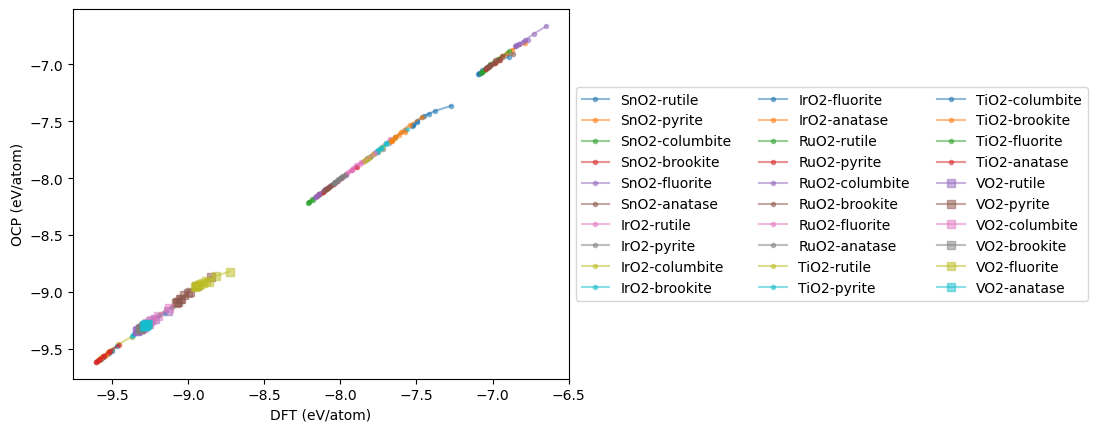

In [75]:
eos_data = {}
for oxide in oxides:
    eos_data[oxide] = {}
    for polymorph in polymorphs:
        dft = []
        ocp = []
        vols = []
        calculations = d[oxide][polymorph]['PBE']['EOS']['calculations']
        for c in calculations:
                        
            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))
            
            atoms.calc = newcalc
            ocp += [atoms.get_potential_energy() / len(atoms)]
            dft += [c['data']['total_energy'] / len(atoms)]
            vols += [atoms.get_volume()]
        plt.plot(dft, ocp, marker='s' if oxide == 'VO2' else '.',
                 alpha=0.5, label=f'{oxide}-{polymorph}')
        eos_data[oxide][polymorph] = (vols, dft, ocp)
        
plt.xlabel('DFT (eV/atom)')
plt.ylabel('OCP (eV/atom)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);

In [76]:
mae = np.mean(np.abs(np.array(dft) - np.array(ocp)))
print(f'New MAE = {mae:1.3f} eV/atom')

New MAE = 0.009 eV/atom


This is a substantial improvement! We can see what it means in terms of the Equations of State. There is still not perfect agreement, but the curves are closer together. Additional fine tuning, or a better model could probably still improve this.

In [ ]:
for oxide in eos_data:
    for polymorph in eos_data[oxide]:
        V, D, O = eos_data[oxide][polymorph]
        plt.figure()
        plt.plot(V, D, label='dft')
        plt.plot(V, O, label='ocp')
        plt.title(f'{oxide} - {polymorph}')
        plt.legend()

TODO: How do you continue improving this?

more epochs?
tighter criteria?
different weights?